In [2]:
import pandas as pd
# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.colors import hex2color, rgb2hex,LinearSegmentedColormap, ListedColormap
import seaborn as sns
import datetime
import json
import numpy as np
from scipy import stats
#import networkx as nx
import os
#from causalimpact import CausalImpact
#from sklearn.preprocessing import normalize

In [3]:
# Main color for the plot
main_color_hex = '#1b1c3a'
main_color = hex2color(main_color_hex)
second_color_hex = '#ffcc03'
second_color = hex2color(second_color_hex)

colors = [main_color, 'black', 'white', second_color] # first color is black, last is red
edmo_divert = LinearSegmentedColormap.from_list(
        "EDMO_divert", colors, N=40)
edmo_cat = ListedColormap(edmo_divert(np.linspace(0, 1, 15)), N=20)
edmo_cat.name = 'EDMO_cat'
mpl.colormaps.register(edmo_divert)
mpl.colormaps.register(edmo_cat)

sns_color_palette_cat = sns.color_palette('tab20')
#sns_color_palette_cat = sns.color_palette('EDMO_divert')
sns.set_style("white")
# Size of the figure to match the latex document

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "figure.figsize" : (4.5, 4),
    "font.size":    11.0,
    'legend.fontsize' : 8,
    'xtick.labelsize' : 9,
    'ytick.labelsize' : 9

})


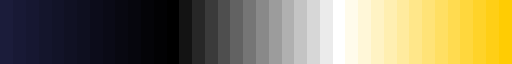

In [4]:
edmo_divert

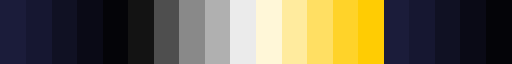

In [5]:
edmo_cat

In [6]:
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [7]:
# Mkdir folder for plots if not existing
folder_plots_eps = './plots/eps/'
os.makedirs(folder_plots_eps, exist_ok=True)
folder_plots_png = './plots/png/'
os.makedirs(folder_plots_png, exist_ok=True)

sample_folders = ['all', 'eval', 'topic_relation', 'on_topic']

for sample_folder in sample_folders:
    eps_path = os.path.join(folder_plots_eps, sample_folder)
    png_path = os.path.join(folder_plots_png, sample_folder)
    os.makedirs(eps_path, exist_ok=True)
    os.makedirs(png_path, exist_ok=True)

### Functions

In [8]:
def extract_value_from_dict(df, colname, val_pos):
    df_temp = pd.json_normalize(df[colname])
    df_temp = df_temp.applymap(lambda x: list(x.values())[val_pos] if isinstance(x, dict) else x)
    df_temp.columns = [f"{colname}_{x}" for x in df_temp.columns]
    df = df.drop(colname, axis=1)
    return pd.concat([df, df_temp], axis=1)

In [9]:
def extract_values(series, key):
    def extract(row):
        values = []
        for d in row:
            if key in d:
                values.append(d[key])
        return values
    return series.apply(extract)

In [10]:
def define_colours(df, column):
    # Define the colour for the fact-checker to be coherent
    colours_fact_checker = dict()
    df = df.explode(column)

    for i, j in enumerate(np.sort(df[column].unique())):
        colours_fact_checker[j] = plt.cm.colors.to_rgba(sns_color_palette_cat[i])
    return colours_fact_checker


def get_values_count(df, column):
    df = df.explode(column)
    df_counts = df[column].value_counts(normalize=False).to_frame().reset_index().set_axis([column, 'Counts'],  axis=1)
    df_counts['Percentages'] = df[column].value_counts(normalize=True).values*100
    df_counts['Percentages'] = df_counts['Percentages'].apply(lambda x: round(x, 1))
    return df_counts


def output_df_for_cross(df, field1, field2, reorder_first=True, reorder_second=True):
    # Generate the groupby df 
    df = df.explode(field1)
    df = df.explode(field2)
    # Count the value and create a table
    df = df.groupby([field1, field2]).size().unstack(fill_value=0)
    # Reorder per first category
    if reorder_first is True:
        df = df.assign(tmp=df.sum(axis=1)).sort_values('tmp', ascending=True).drop(labels='tmp', axis=1)
    # Reorder for the second category
    if reorder_second is True:
        df = df.transpose().assign(tmp=df.sum(axis=0)).sort_values('tmp', ascending=False).drop(labels='tmp', axis=1).transpose()
    # Normalised
    df_norm = df.div(df.sum(axis=1), axis=0)

    return df, df_norm

In [11]:
def plot_counts(df, column, color=main_color, kind_bar='bar', width_bar=0.9): 
                
    fig, ax = plt.subplots()
    sns.despine(offset=5, trim=False);    
    # In case of horizontal plot, reorder to avoid having the highest count at the bottom
    if kind_bar == 'barh':
        df = df.sort_values(by='Counts', ascending=True)   
    df.plot(kind=kind_bar, x=column, y='Counts', stacked=True,ax=ax, legend=None, width=width_bar, color=color)
    ax.set(xlabel= column)
    ax.set(ylabel='Count')
    ax.tick_params(rotation=0)
    filename = f'{column}'
    save_plot(fig, ax, filename, sample, legend=None)
    return plt



def plot_cross(df, field1, field2, colours, legend_position=None, width_bar=1, norm=False):

    fig, ax = plt.subplots()
    if norm:
        sns.despine(offset=None, trim=False, left=True, bottom=True)
        filename = f"{field1}_{field2}_norm"
    else:
        sns.despine(offset=5, trim=False);
        filename = f"{field1}_{field2}"
    df.plot.barh(stacked=True, ax=ax, color= color_palette, width=width_bar, linewidth=0.3)
    ax.set(xlabel='Count')
    ax.set(ylabel=f'claims_{field1}')
    ax.tick_params(rotation=0)
    save_plot(fig, ax, filename, sample, legend_position=legend_position)
    return plt

def plot_per_day(df, column, colours, legend_position=None, width_bar=0.9):
    
    fig, ax = plt.subplots()
    sns.despine(offset=5, trim=False);
    df.plot(kind='bar', ax=ax, stacked=True, color=colours, width=width_bar) 
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.set(xlabel='Dates')
    ax.set(ylabel='Count')
    ax.tick_params(rotation=90)
    filename = f'claims_{column}_per_days'
    save_plot(fig, ax, filename, sample, legend_position=legend_position)
    return plt

def save_plot(fig, ax, filename, sample, half_sise=False, png_size=None, eps_size=None, legend=None, legend_position=None):
    
    def despine(ax, color):
        try:
            for spine in ax.spines.values():
                spine.set_edgecolor(color)
            ax.tick_params(axis='both', colors=color)
            ax.xaxis.label.set_color(color)
            ax.yaxis.label.set_color(color)
        except AttributeError:
            for axs in ax:
                despine(axs, color)
                
    def change_font_size(ax, fontsize):
        try:
            for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(fontsize)
        except AttributeError:
            for axs in ax:
                change_font_size(axs, fontsize)
                
    def tweak_legend(ax, legend_position, legend, fontsize, color, remove_background=False):
            # set the color of the legend text
        try:

            if legend_position or legend:

                leg = ax.get_legend()
                for text in leg.get_texts():
                    plt.setp(text, color = color)
                    text.set_fontsize(fontsize)
                leg._legend_title_box._text.set_color(color)
                # Remove the legend background
                if remove_background:
                    leg.get_frame().set_alpha(None)
                    leg.get_frame().set_facecolor('none')
                    leg.get_frame().set_linewidth(0)
                if legend_position:
                    ax.legend(bbox_to_anchor=legend_position, loc="upper left")
                    #fig.artists.append(leg) # Here's the change
                    #fig.legend(loc=legend_position)
        except AttributeError:
            tweak_legend(ax[0], legend_position, legend, fontsize, color)
        
    if png_size:
        fig.set_size_inches(png_size)
    else:
        fig.set_size_inches(7, 7)
    despine(ax, 'grey')

    # Increase font size of everything
    fontsize = 16
    fontsize_legend = 12

    color_legend = 'grey'
    color_text = 'grey'
    change_font_size(ax, fontsize)
    tweak_legend(ax, legend_position, legend, fontsize_legend, color_legend)       
            
 #
    fig.savefig(f'./plots/png/{sample}/{sample}_{filename}.png', pad_inches=0.1, bbox_inches='tight', dpi=600)

    if eps_size:
        fig.set_size_inches(eps_size)

    despine(ax, 'grey')
    fontsize = 11
    fontsize_legend = 9
    color_legend = 'grey'
    color_text = 'grey'
    change_font_size(ax, fontsize)
    tweak_legend(ax, legend_position, legend, fontsize_legend, color_legend)       
            
    fig.savefig(f'./plots/eps/{sample}/{sample}_{filename}.eps', bbox_inches='tight', pad_inches=0.1, dpi=600)


# Loading data

In [12]:
with open('./../data/dumps/maldita.json', 'r') as f:
    json_iberifier = json.load(f)
df_iberifier = pd.json_normalize(json_iberifier)
df_iberifier['formats'] = extract_values(df_iberifier['formats'], 'name')
df_iberifier['sources'] = extract_values(df_iberifier['sources'], 'name')
df_iberifier['categories'] = extract_values(df_iberifier['categories'], 'name')

# Drop unused columns
to_drop = ['organization.id', 'debunkContent', 'media', 'keywords', 'organizationCalification.calification.id']
for col in to_drop:
    df_iberifier = df_iberifier.drop(col, axis=1)
    
# Rename some columns for easy viz

rename_cols = {'_id.$oid': 'fact_id', 
               'type.name': 'type',
               'organization.name': 'fact_checker',
               'organizationCalification.calification.explanation': 'explanation', 
               'organizationCalification.calification.name': 'qualification',
               'date.$date': 'date'}
df_iberifier = df_iberifier.rename(columns=rename_cols)

# Convert datetime object
df_iberifier['date'] = df_iberifier['date'].astype('datetime64[ns]').dt.date


# Replace some nan value with None is some column to avoid issues with np
df_iberifier['type'] = df_iberifier['type'].replace(to_replace=np.nan, value='None')

df_iberifier.head(1)

,text,content,formats,createdAt,sources,categories,link,fact_id,type,fact_checker,qualification,explanation,date
0,"No, esta agresión a un médico que atiende a un...","España, cada vez más frecuentes los ataques a ...",[Vídeo],2023-03-08T09:11:42+01:00,"[WhatsApp, Twitter]","[Migración/Migraçao - Racismo, Religión / Reli...",https://maldita.es/malditobulo/20230308/agresi...,6409218c5966ae90e851a389,Otros / Outros,Maldita.es,Falso,Se ha contrastado de forma independiente que e...,2023-03-08


In [13]:
with open('./../data/dumps/tweets.json', 'r') as f:
    json_tweets = json.load(f)
df_tweets = pd.json_normalize(json_tweets)
df_tweets['fact_id'] = extract_values(df_tweets['fact_id'], '$oid')

# Drop unused columns
to_drop = ['tweet.in_reply_to_user.withheld.scope', 'tweet.withheld.scope', 'tweet.attachments.poll_ids', 'tweet.author.withheld.scope']
for col in to_drop:
    df_tweets = df_tweets.drop(col, axis=1)

# Rename some columns for easy viz
rename_cols = {'_id.$oid': 'db_id', 
               'date.$date': 'date', 
               'tweet.public_metrics.retweet_count': 'retweet_count',
               'tweet.public_metrics.like_count': 'like_count',
               'tweet.public_metrics.quote_count': 'quote_count',
               'tweet.public_metrics.impression_count': 'impression_count',
               'tweet.public_metrics.reply_count': 'reply_count'
              }

df_tweets = df_tweets.rename(columns=rename_cols)



# Convert datetime object
df_tweets['date'] = df_tweets['date'].astype('datetime64[ns]').dt.date
df_tweets.head(1)

,tweet_id,fact_id,text,topic_relation,claim_relation,db_id,date,retweet_count,reply_count,like_count,...,tweet.in_reply_to_user.location,tweet.in_reply_to_user.id,tweet.in_reply_to_user.name,tweet.attachments.media_keys,tweet.attachments.media,claim_finer_relation,tweet.withheld.copyright,tweet.withheld.country_codes,tweet.author.withheld.country_codes,tweet.in_reply_to_user.withheld.country_codes
0,1631080654195572736,[6409218c5966ae90e851a389],"@wallstwolverine No sé, aquí hay mitad y mitad...",off-topic,off-claim,6413ae166fa02fd2fb322358,2023-03-01,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
with open('./../data/dumps/mynews.json', 'r') as f:
    json_mynews = json.load(f)
df_mynews = pd.json_normalize(json_mynews)


# Rename some columns for easy viz

rename_cols = {'_id.$oid': 'db_id', 
               'date.$date': 'date', 
               'fact_id.$oid': 'fact_id'
              }

df_mynews = df_mynews.rename(columns=rename_cols)

# Convert datetime object
df_mynews['date'] = df_mynews['date'].astype('datetime64[ns]').dt.date

df_mynews.head(1)

,IdDocument,Title,Section,Date,Author,Newspaper,Subtitle,Page,Content,GeneralReference,...,Audience,Logo,Ref,query_output,keywords_in_title,topic_relation,db_id,fact_id,date,not_keywords_title
0,00009100-20230303-000039,"2 marzo, 2023 Lo mejor que le ha pasado a NVID...",,03/03/2023,,Gerente.com El Portal de Negocios,,https://gerente.com/es/new-rss/lo-mejor-que-le...,[2622 Caracteres]HomePaisMercadosInternacional...,,...,39613.0,None,9100,4118,True,off-topic,6413ae93de7d0add923cb1e9,6409218c5966ae90e851a389,2023-03-03,NaN


In [15]:
with open('./../data/dumps/keywords.json', 'r') as f:
    json_keywords = json.load(f)
    


df_keywords = pd.json_normalize(json_keywords)

rename_cols = {'_id.$oid': 'db_id', 
               'date.$date': 'date', 
               'fact_id.$oid': 'fact_id'
              }
df_keywords = df_keywords.rename(columns=rename_cols)


df_keywords.head(1)

,url_fact,calification,categories,claim,review,keywords,keywords_pairs,search_twitter_key,search_mynews_key,db_id,...,pos_review.NUM,pos_review.X,search_twitter_key.$date,search_mynews_key.$date,pos_claim.AUX,pos_review.AUX,ner_claim.PUB,ner_claim.PESSOA,ner_review.PUB,ner_review.PESSOA
0,https://maldita.es/malditobulo/20230308/agresi...,Falso,"[{'id': 8, 'name': 'Migración/Migraçao - Racis...","España, cada vez más frecuentes los ataques a ...","No, esta agresión a un médico que atiende a un...","[españa, frecuentes, hay, rusia, vez]",[],1.0,1.0,640ef4066fa02fd2fb2d6ad8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Subsetting mask creation

In [16]:
# Subsetting 

# EVAL 
## Iberifier
mask_eval_iberifier =  (df_iberifier['qualification'] == 'Falso') & (df_iberifier['fact_checker'].isin(['Maldita.es', 'EFE Verifica', 'Newtral']))
df_iberifier['experience_subset'] = mask_eval_iberifier
#### Get the list of valid fact_ids to mask the other sets
list_fact_id_eval = df_iberifier[df_iberifier['experience_subset'] == True]['fact_id'].to_list()

## Tweets
mask_tweets_eval = df_tweets['fact_id'].apply(lambda x: any(item in list_fact_id_eval for item in x))
df_tweets['experience_subset'] = mask_tweets_eval

## Mynews
mask_mynews_eval =  df_mynews['fact_id'].isin(list_fact_id_eval)
df_mynews['experience_subset'] = mask_mynews_eval

## Keywords
mask_keywords_eval =  df_keywords['fact_id'].isin(list_fact_id_eval)
df_keywords['experience_subset'] = mask_keywords_eval

# TOPIC_RELATION
## Tweets
mask_tweets_topic_relation = df_tweets['topic_relation'].notnull() & mask_tweets_eval
df_tweets['topic_relation_subset'] = mask_tweets_topic_relation

## Mynews
mask_mynews_topic_relation = df_mynews['topic_relation'].notnull() & mask_mynews_eval
df_mynews['topic_relation_subset'] = mask_mynews_topic_relation

## Iberifier
### Getting the list of present fact_ids in mynews and tweets from topic_relation. For tweets they may be several fact_ids for one tweet
list_factids_topic_relation_tweets = df_tweets[df_tweets['topic_relation_subset'] ==True].explode('fact_id')['fact_id'].to_list()
list_factids_topic_relation_mynews = df_mynews[df_mynews['topic_relation_subset'] == True]['fact_id'].to_list()
list_factids_topic_relation = list_factids_topic_relation_tweets + list_factids_topic_relation_mynews

mask_iberifier_topic_relation = df_iberifier['fact_id'].isin(list_factids_topic_relation)
df_iberifier['topic_relation_subset'] = mask_iberifier_topic_relation

# On-Topic
## Tweets
mask_tweets_on_topic = (df_tweets['topic_relation'] == 'on-topic') & mask_tweets_topic_relation
df_tweets['on_topic_subset'] = mask_tweets_on_topic
## Mynews
mask_mynews_on_topic = (df_mynews['topic_relation'] == 'on-topic') & mask_mynews_topic_relation
df_mynews['on_topic_subset'] = mask_mynews_on_topic

## Iberifier
### Getting the list of present fact_ids in mynews and tweets from topic_relation. For tweets they may be several fact_ids for one tweet
list_factids_on_topic_tweets = df_tweets[df_tweets['on_topic_subset'] ==True].explode('fact_id')['fact_id'].to_list()
list_factids_on_topic_mynews = df_mynews[df_mynews['on_topic_subset'] == True]['fact_id'].to_list()
list_factids_on_topic = list_factids_on_topic_tweets + list_factids_on_topic_mynews
mask_iberifier_on_topic = df_iberifier['fact_id'].isin(list_factids_on_topic)

df_iberifier['on_topic_subset'] = mask_iberifier_on_topic

# Data about the entire dataset

### Comparison data between the different subsets

## Number of records per subset

In [19]:
number_claims_all = len(df_iberifier.index)
number_claims_eval = len(df_iberifier[df_iberifier['experience_subset'] == True].index)
number_claims_topic_relation =  len(df_iberifier[df_iberifier['topic_relation_subset'] == True].index)
number_claims_on_topic = len(df_iberifier[df_iberifier['on_topic_subset'] == True].index)

number_tweets_all = len(df_tweets.index)
number_tweets_eval = len(df_tweets[df_tweets['experience_subset'] == True].index)
number_tweets_topic_relation = len(df_tweets[df_tweets['topic_relation_subset'] == True].index)
number_tweets_on_topic = len(df_tweets[df_tweets['on_topic_subset'] == True].index)

number_news_all = len(df_mynews.index)
number_news_eval = len(df_mynews[df_mynews['experience_subset'] == True].index)
number_news_topic_relation = len(df_mynews[df_mynews['topic_relation_subset'] == True].index)
number_news_on_topic = len(df_mynews[df_mynews['on_topic_subset'] == True].index)

all_count = [number_claims_all, number_news_all, number_tweets_all ]
eval_count = [number_claims_eval, number_news_eval, number_tweets_eval]
topic_relation_count = [number_claims_topic_relation, number_news_topic_relation, number_tweets_topic_relation]
on_topic_count = [number_claims_on_topic, number_news_on_topic,  number_tweets_on_topic]

datasources = ['Claims','News',  'Tweets', ]
df_overview = pd.DataFrame({'Data source': datasources*4, 'Dataset': ['All']*3+['Evaluation']*3+['Topic analysis']*3+['On topic']*3, 'Counts': all_count+eval_count+topic_relation_count+on_topic_count})
df_overview#.plot(kind='bar')
table = df_overview.pivot(index='Data source', columns='Dataset', values='Counts')
table = table.reindex(columns=['All', 'Evaluation', 'Topic analysis', 'On topic'])
table.to_csv(f"./tables/overview_datasets.csv")
table

Dataset,All,Evaluation,Topic analysis,On topic
Data source,,,,
Claims,191,94,94,92
News,1563,1319,1319,682
Tweets,115873,71598,71598,13211


NameError: name 'df_overview' is not defined

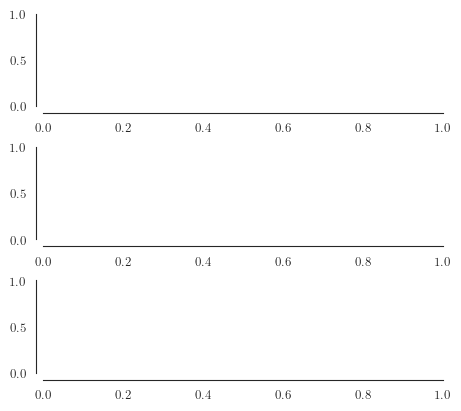

In [18]:
# define the subplots
fig, ax = plt.subplots(3, layout='constrained')

sns.despine(offset=5, trim=False)

# plot each line in a separate subplot
sns.barplot(data=df_overview[df_overview['Data source'] == 'Claims'], x='Data source', y='Counts', hue='Dataset',  ax=ax[0])
sns.barplot(data=df_overview[df_overview['Data source'] == 'Tweets'], x='Data source', y='Counts', hue='Dataset',  ax=ax[1])
sns.barplot(data=df_overview[df_overview['Data source'] == 'News'], x='Data source', y='Counts', hue='Dataset',  ax=ax[2])

#sns.barplot(data=df_overview, x='diff_date', y='reply_count', hue='claim_finer_relation', palette=[main_color, second_color], ax=ax[1], legend=None)
#sns.barplot(data=df_overview, x='diff_date', y='like_count', hue='claim_finer_relation',palette=[main_color, second_color],  ax=ax[2], legend=None)


# add titles and axis labels
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')


# Removing y-axis labels
#ax[0].set_ylabel('')
#ax[1].set_ylabel('')
#ax[2].set_ylabel('')


#fig.legend(loc='outside lower center', ncol=2)
ax[0].legend().remove()
ax[1].legend().remove()
ax[2].legend().remove()
ax[0].legend(bbox_to_anchor=(1,1), loc="upper left")

filename = f'overview_subsets'
save_plot(fig, ax, filename, 'all')
plt.show()

In [20]:
print(f"Number of claims: {len(df_iberifier)}")
print(f"Number of Tweets: {len(df_tweets)}")
print(f"Number of News Articles: {len(df_mynews)}")

Number of claims: 191
Number of Tweets: 115873
Number of News Articles: 1563


## Time period

### IBERIFIER API

In [21]:
print(f" First day for Iberifier API: {min(df_iberifier['date'])}")
print(f" Last day for Iberifier API: {max(df_iberifier['date'])}")
print(f" Lenght period for Iberifier API: {max(df_iberifier['date']) - min(df_iberifier['date']) }")

 First day for Iberifier API: 2023-03-08
 Last day for Iberifier API: 2023-04-05
 Lenght period for Iberifier API: 28 days, 0:00:00


### Twitter API

In [20]:
print(f" First day for Twitter: {min(df_tweets['date'])}")
print(f" Last day for Twitter: {max(df_tweets['date'])}")
print(f" Lenght period for Twitter: {max(df_tweets['date']) - min(df_tweets['date']) }")

 First day for Twitter: 2023-03-01
 Last day for Twitter: 2023-04-12
 Lenght period for Twitter: 42 days, 0:00:00


### MyNews API

In [21]:
print(f" First day for MyNews: {min(df_mynews['date'])}")
print(f" Last day for MyNews: {max(df_mynews['date'])}")
print(f" Lenght period for MyNews: {max(df_mynews['date']) - min(df_mynews['date']) }")

 First day for MyNews: 2023-03-02
 Last day for MyNews: 2023-04-12
 Lenght period for MyNews: 41 days, 0:00:00


### Keyword extraction

## Sampling

In [22]:
# Filtering or not
sample = 'on_topic' # 'eval' on_topic

if sample == 'eval':
    df_iberifier = df_iberifier[df_iberifier['eval_subset'] == True]
    df_keywords = df_keywords[df_keywords['eval_subset'] == True]
    df_mynews = df_mynews[df_mynews['eval_subset'] == True]
    df_tweets = df_tweets[df_tweets['eval_subset'] == True]
    
elif sample == 'topic_relation':
    df_mynews = df_mynews[df_mynews['topic_relation_subset'] == True]
    df_tweets = df_tweets[df_tweets['topic_relation_subset'] == True]
    
elif sample == 'on_topic':
    df_mynews = df_mynews[df_mynews['on_topic_subset'] == True]
    df_tweets = df_tweets[df_tweets['on_topic_subset'] == True]

## Information about the IBERIFIER API

### Column description

#### Fact-checker

In [23]:
field = 'fact_checker'

# Define the colour for the fact-checker to be coherent
colours_fact_checker = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

##### Table

In [24]:
field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")
field_counts

,fact_checker,Counts,Percentages
0,Newtral,77,40.3
1,Maldita.es,60,31.4
2,Polígrafo,33,17.3
3,Verificat,14,7.3
4,EFE Verifica,7,3.7


##### Count Plot

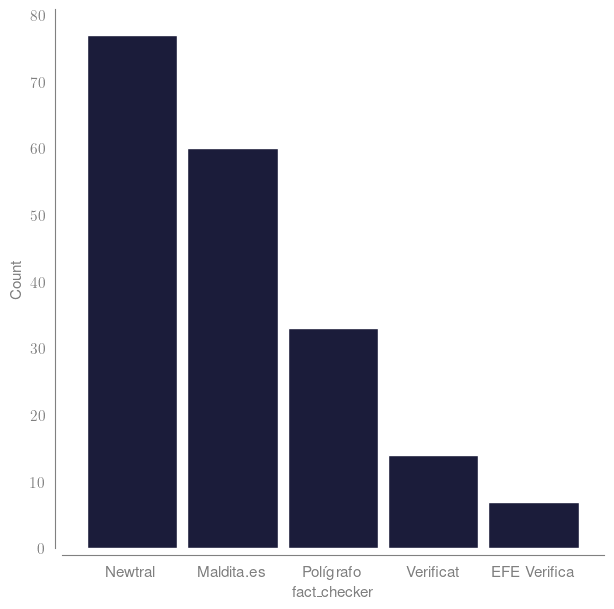

In [25]:
plot_count = plot_counts(field_counts, field)

##### Per day

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


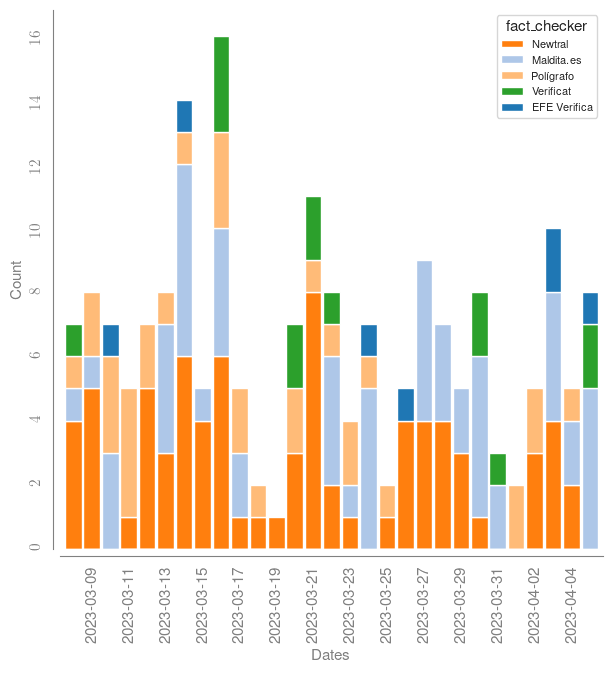

In [26]:
plot_day= plot_per_day(field_dates, field, colours_fact_checker)

#### Qualification of claim

In [27]:
field = 'qualification'

# Define the colour for the fact-checker to be coherent
colours_qualification_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

##### Table

In [28]:
field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")
field_counts

,qualification,Counts,Percentages
0,Falso,124,64.9
1,Verdadero / Verdadeiro,24,12.6
2,Explainer,22,11.5
3,Engañoso / Enganador,13,6.8
4,No verificable / Não verificável,4,2.1
5,Manipulado,4,2.1


##### Counts Plot

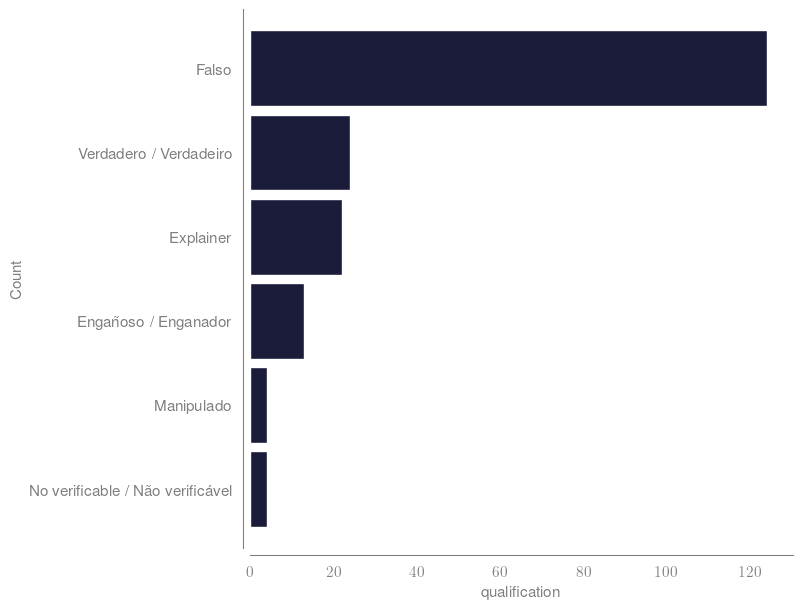

In [29]:
plot_count = plot_counts(field_counts, field, kind_bar='barh')

##### Per day

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


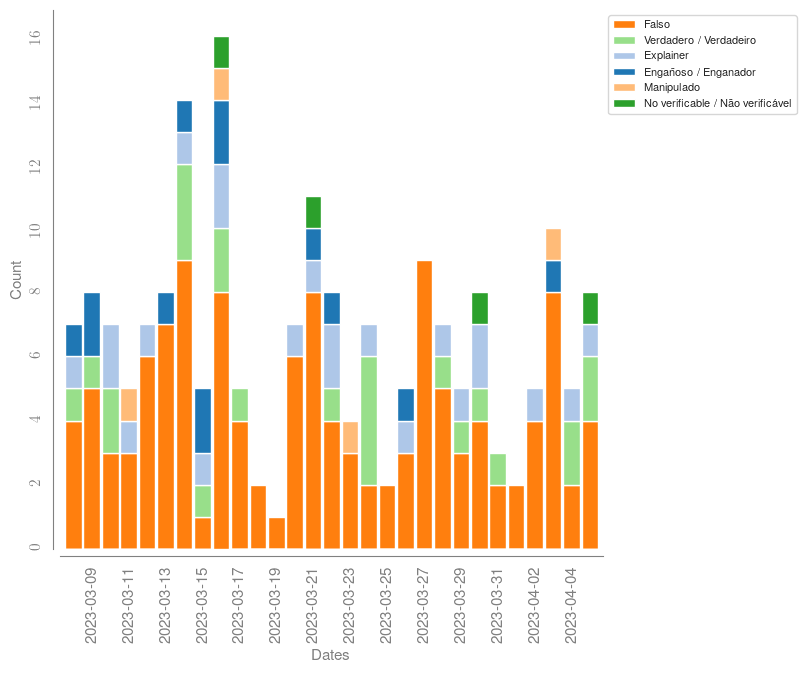

In [30]:
plot_day= plot_per_day(field_dates, field, colours_qualification_claims, legend_position=(1,1))

#### Category of claim

In [31]:
field = 'categories'

# Define the colour for the fact-checker to be coherent
colours_cat_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

##### Table

In [32]:
field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")
field_counts

,categories,Counts,Percentages
0,Política,64,21.1
1,Social,52,17.1
2,Personajes / Personagens,26,8.6
3,Timo / Fraude,24,7.9
4,Otro / Outros,24,7.9
5,Ciencia / Ciência,21,6.9
6,Salud / Saúde,15,4.9
7,Género / Gênero,15,4.9
8,Consumo,12,3.9
9,Migración/Migraçao - Racismo,11,3.6


##### Counts Plot

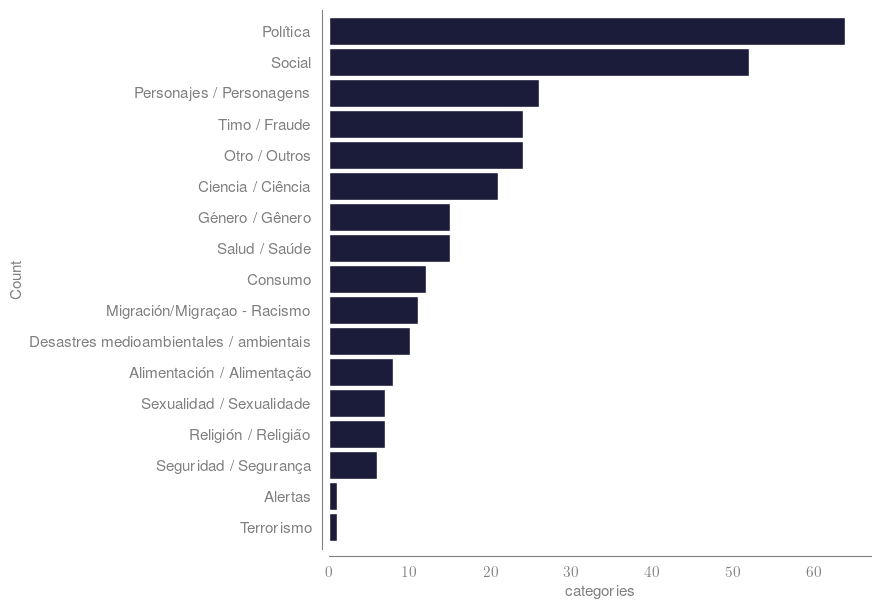

In [33]:
plot_count = plot_counts(field_counts, field, kind_bar='barh')

##### Per day

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


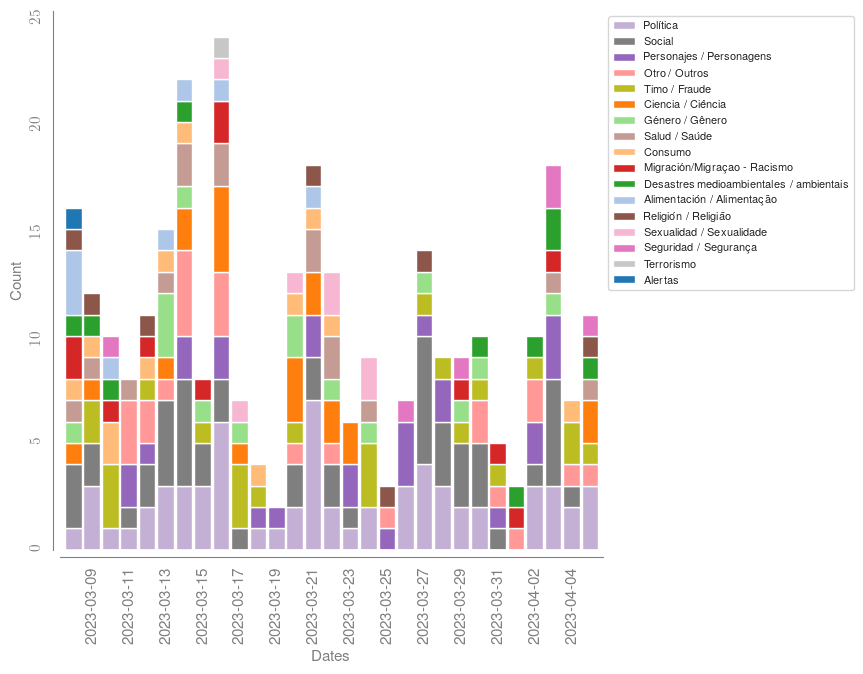

In [34]:
plot_day= plot_per_day(field_dates, field, colours_cat_claims, legend_position=(1,1))#legend_position='outside lower center')

#### Source of claim

In [35]:
field = 'sources'

# Define the colour for the fact-checker to be coherent
colours_source_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

##### Table

In [36]:
field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")
field_counts

,sources,Counts,Percentages
0,Twitter,81,28.9
1,Facebook,77,27.5
2,Otros / Outros,63,22.5
3,WhatsApp,27,9.6
4,TikTok,20,7.1
5,Telegram,5,1.8
6,Buscador,4,1.4
7,Instagram,3,1.1


##### Counts Plot

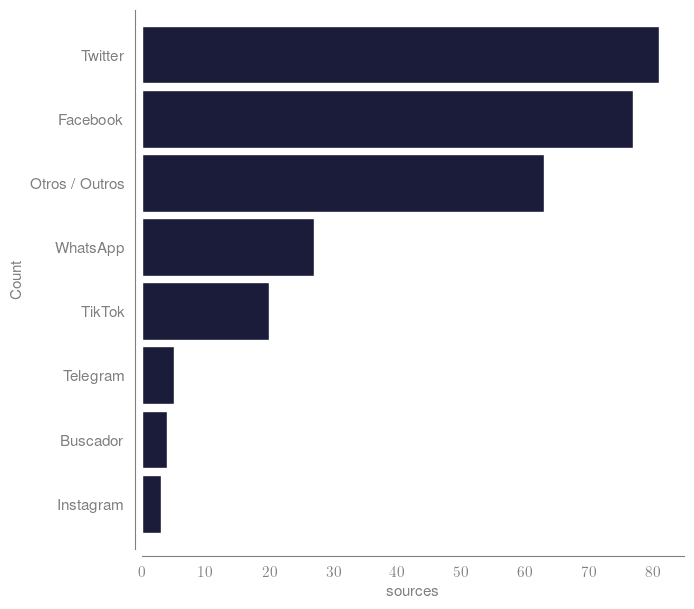

In [37]:
plot_count = plot_counts(field_counts, field, kind_bar='barh')

##### Per day

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


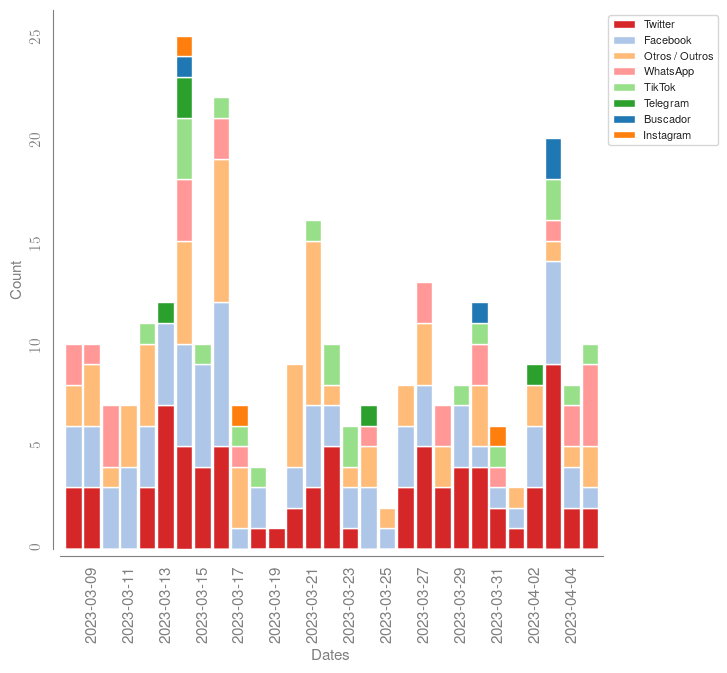

In [38]:
plot_day= plot_per_day(field_dates, field, colours_source_claims, legend_position=(1,1))

#### Type of false information

In [39]:
field = 'type'

# Define the colour for the fact-checker to be coherent
colours_type_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

##### Table

In [40]:
field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")
field_counts

,type,Counts,Percentages
0,Contexto falso - Información / Informação falsa,49,25.7
1,Otros / Outros,43,22.5
2,Contenido/Conteúdo manipulado,26,13.6
3,Cita falsa / Citação falsa,23,12.0
4,Timo / Fraude,17,8.9
5,Invent,17,8.9
6,None,10,5.2
7,Alerta falsa/falso,5,2.6
8,Sátira,1,0.5


##### Counts Plot

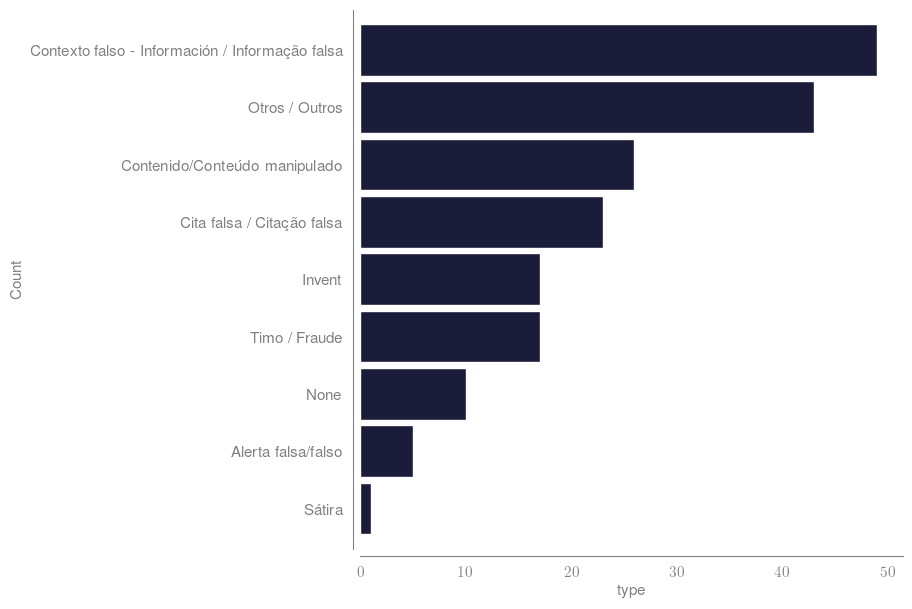

In [41]:
plot_count = plot_counts(field_counts, field, kind_bar='barh')

##### Per day

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


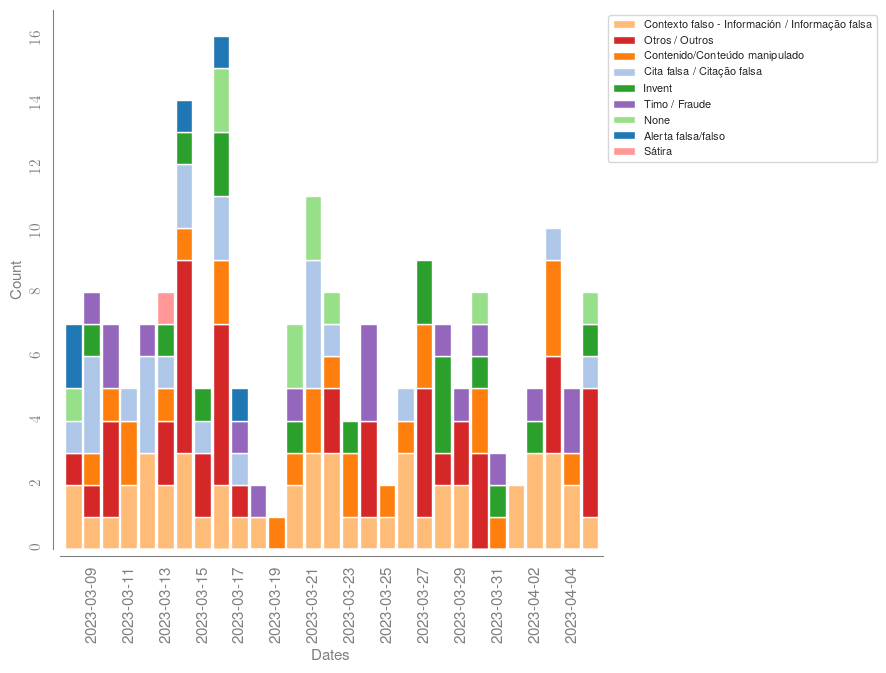

In [42]:
plot_day= plot_per_day(field_dates, field, colours_type_claims, legend_position=(1, 1))

### Crossing columns

#### Fact-checker VS Qualifications

In [43]:
field1 = 'fact_checker'
field2 = 'qualification'
color_palette = colours_qualification_claims
df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

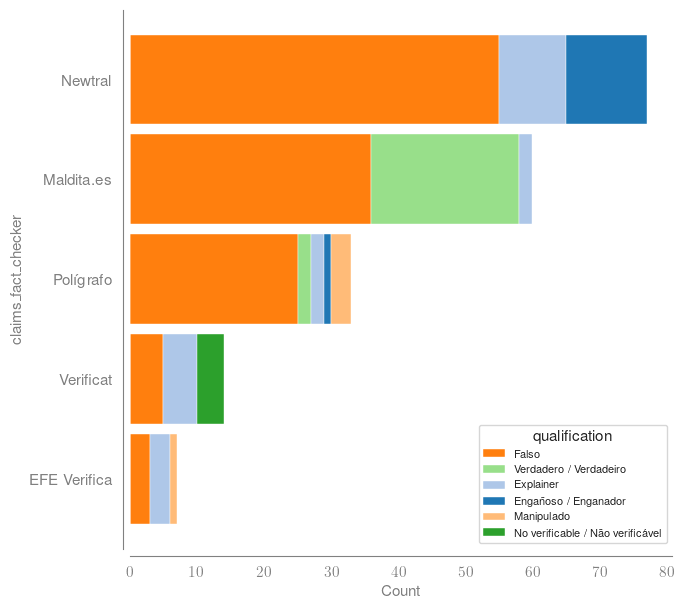

In [44]:
plot_cross(df_to_plot, field1, field2, color_palette, legend_position=None, width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

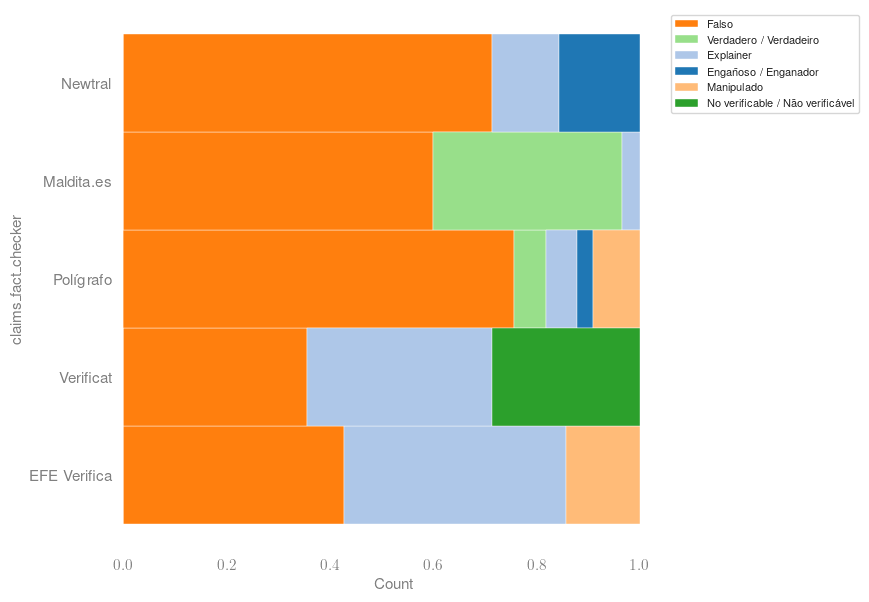

In [45]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Fact-checker VS Category

In [46]:
field1 = 'fact_checker'
field2 = 'categories'
color_palette = colours_cat_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

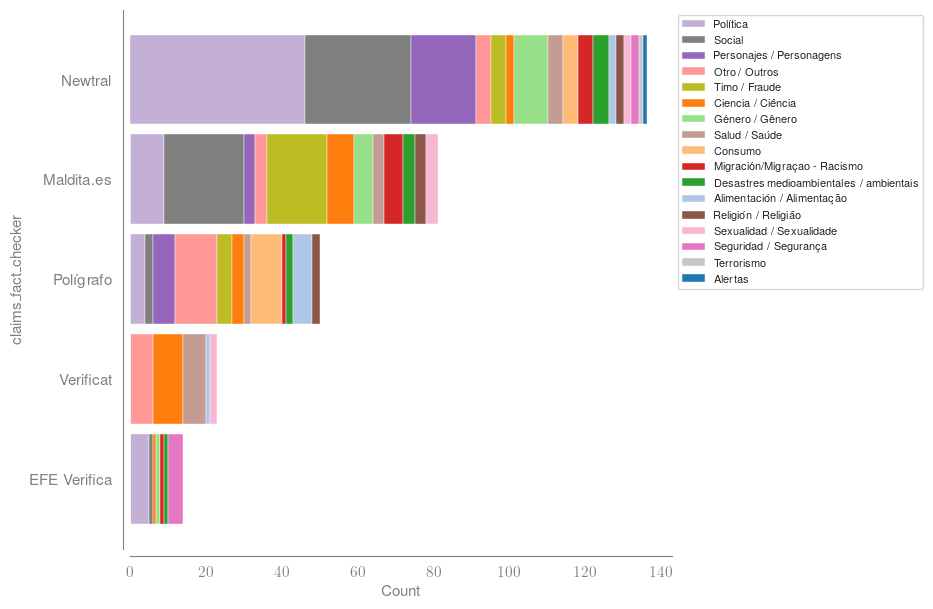

In [47]:
plot_cross(df_to_plot, field1, field2, color_palette, legend_position=(1,1), width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

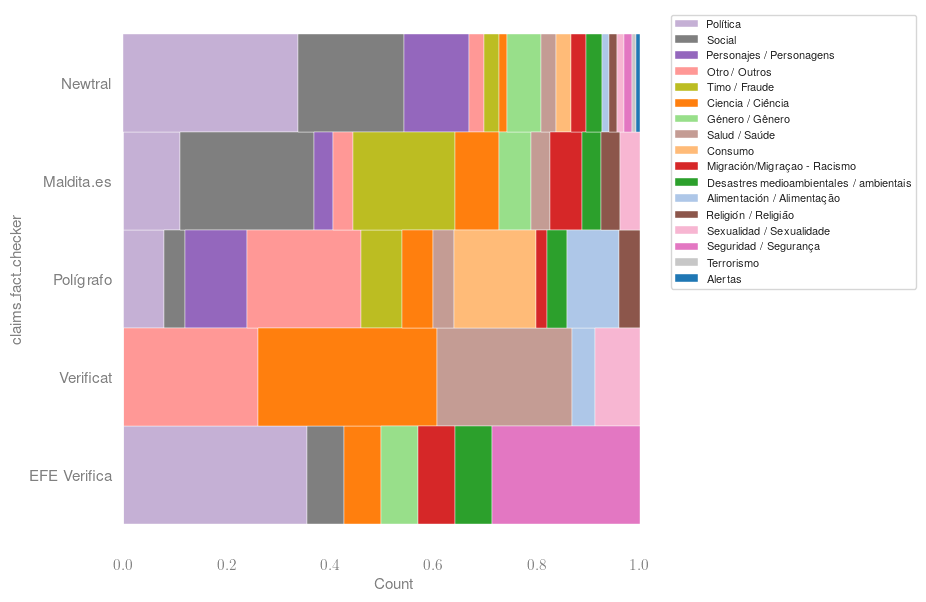

In [48]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Fact-checker VS Sources

In [49]:
field1 = 'fact_checker'
field2 = 'sources'
color_palette = colours_source_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

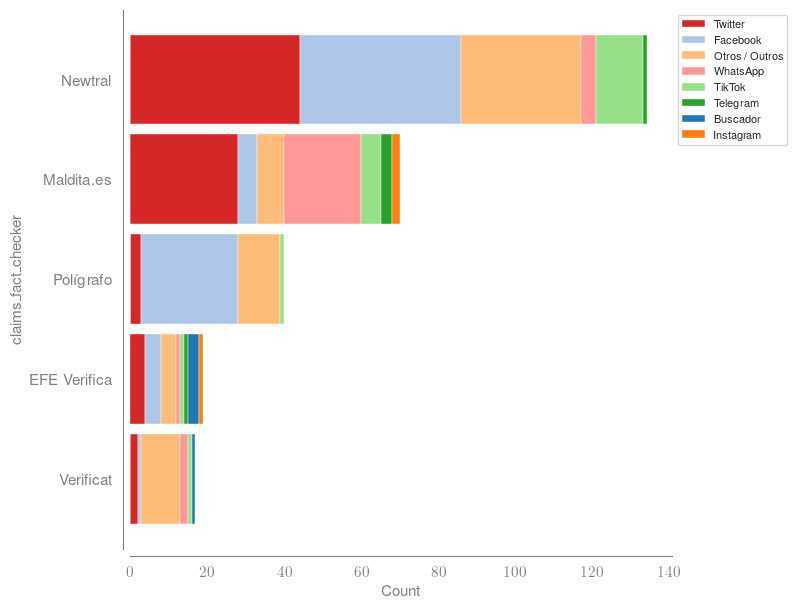

In [50]:
plot_cross(df_to_plot, field1, field2, color_palette, legend_position=(1,1), width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

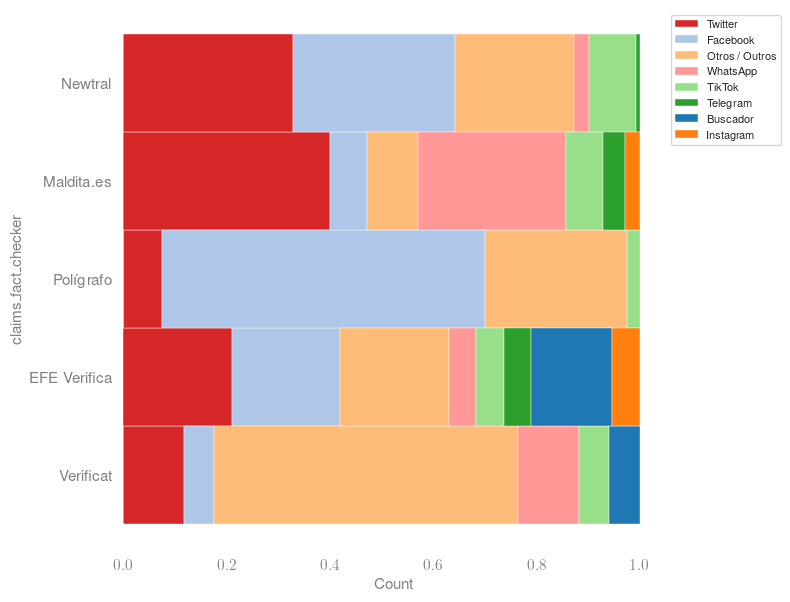

In [51]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Fact-checker VS Type of false info

In [52]:
field1 = 'fact_checker'
field2 = 'type'
color_palette = colours_type_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

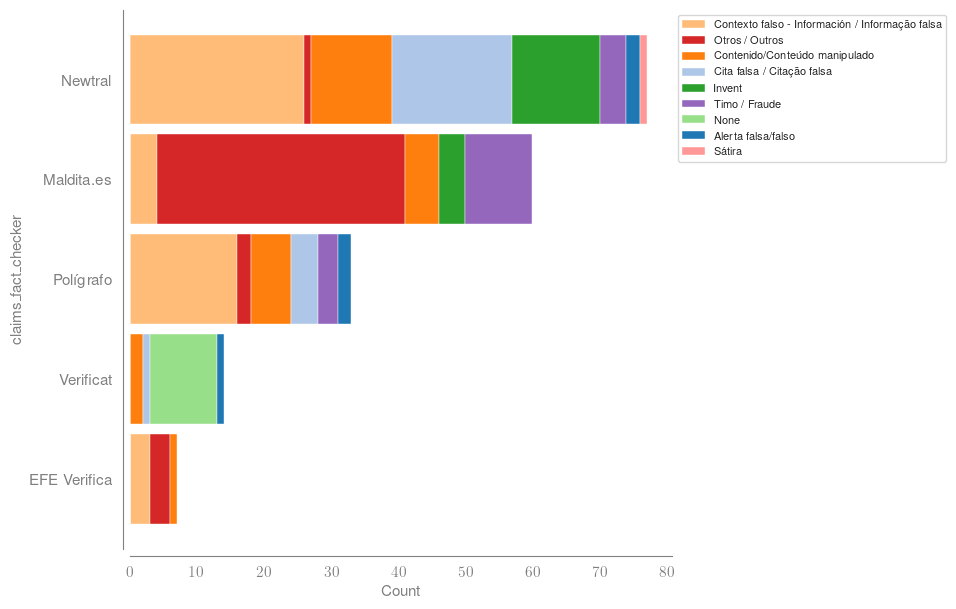

In [53]:
plot_cross(df_to_plot, field1, field2, color_palette, legend_position=(1,1), width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

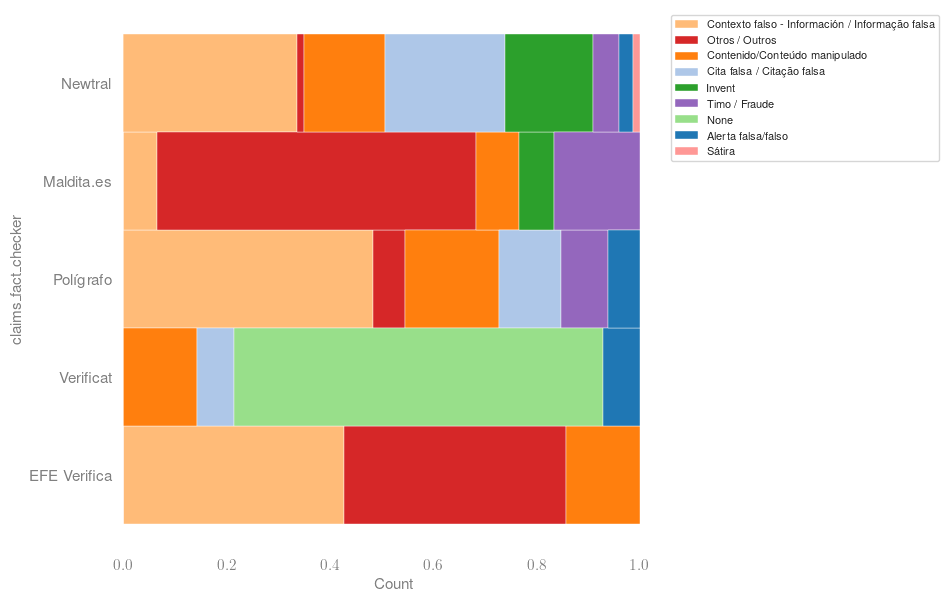

In [54]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Qualification VS Category

In [123]:
field2 = 'qualification'
field1 = 'categories'
color_palette = colours_qualification_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

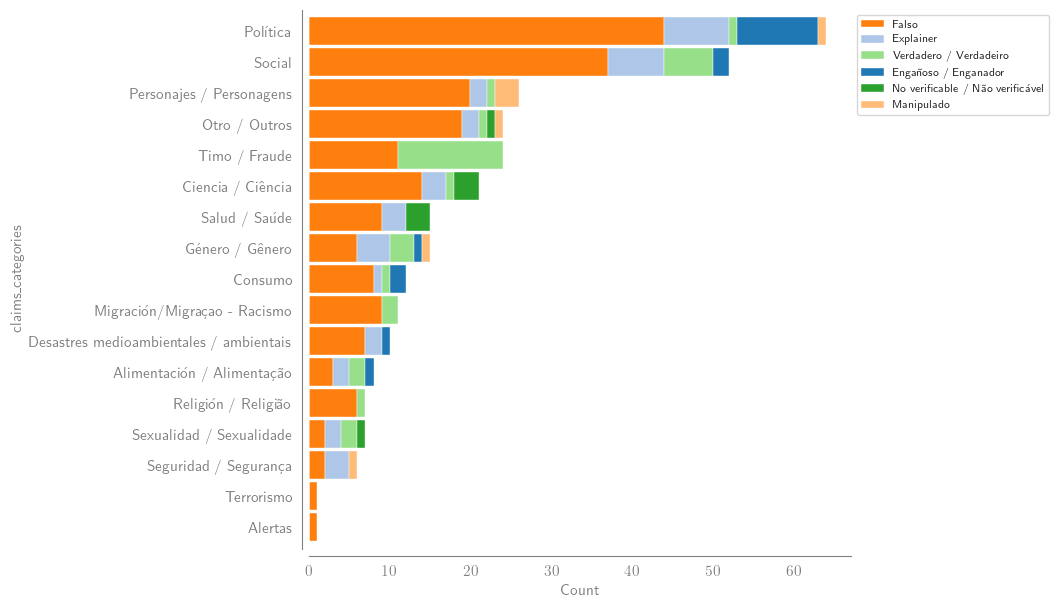

In [124]:
plot_cross(df_to_plot, field1, field2, color_palette, legend_position=(1,1), width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

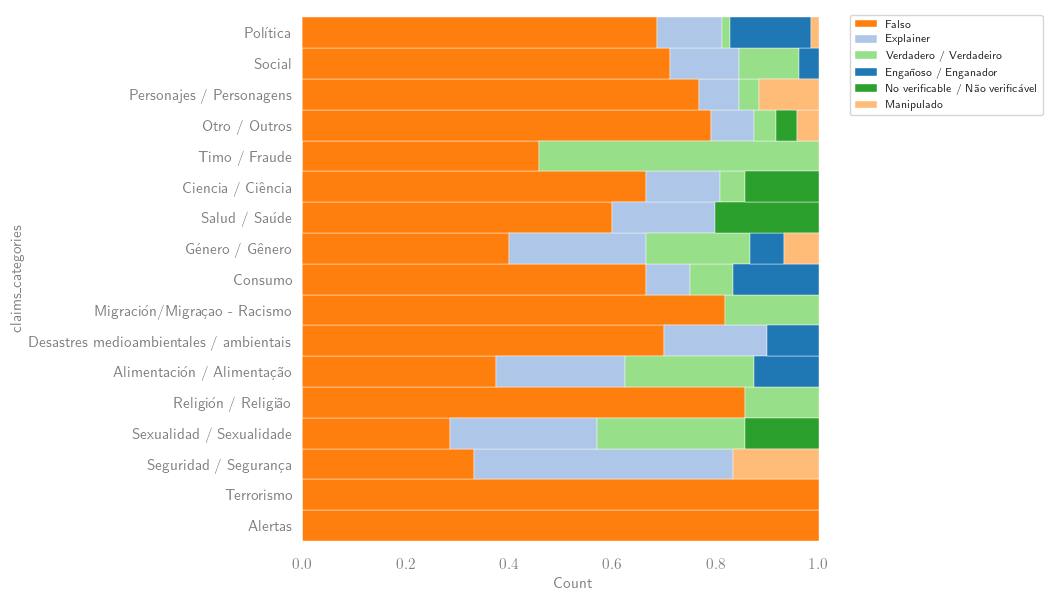

In [125]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Qualification VS Source

In [126]:
field1 = 'qualification'
field2 = 'sources'
color_palette = colours_source_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

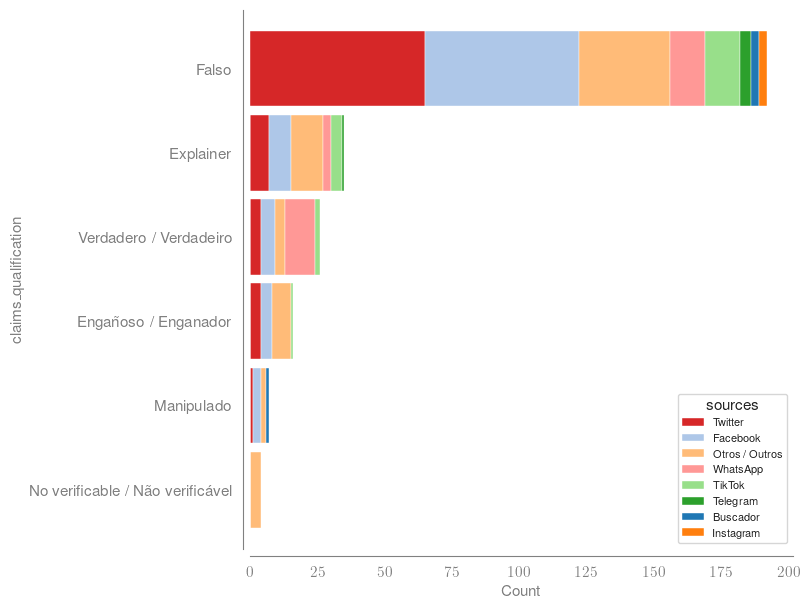

In [59]:
plot_cross(df_to_plot, field1, field2, color_palette, width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

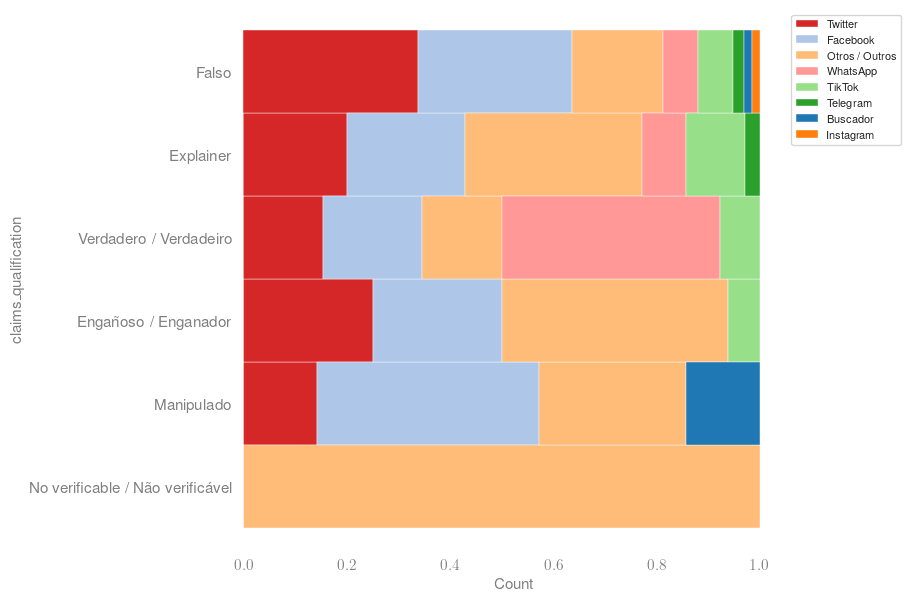

In [60]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Qualification VS Type of False info

In [61]:
field1 = 'qualification'
field2 = 'type'
color_palette = colours_type_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

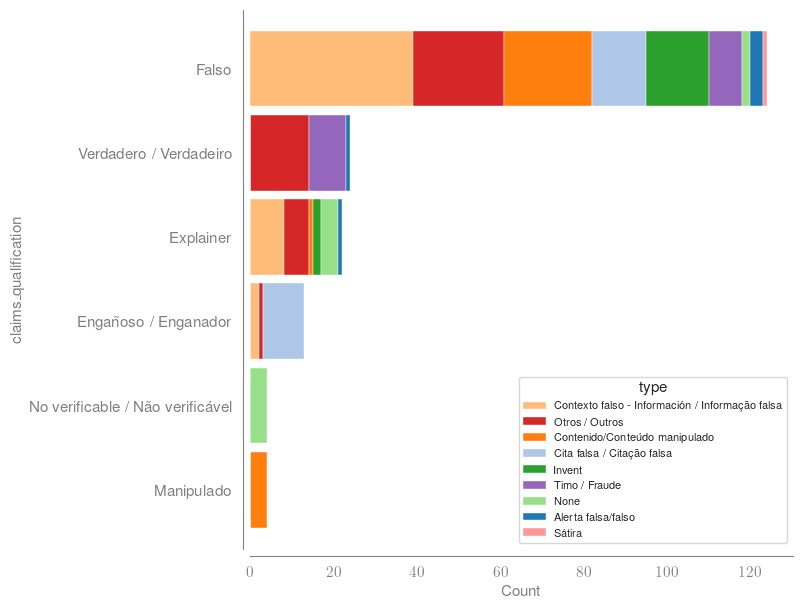

In [62]:
plot_cross(df_to_plot, field1, field2, color_palette, width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

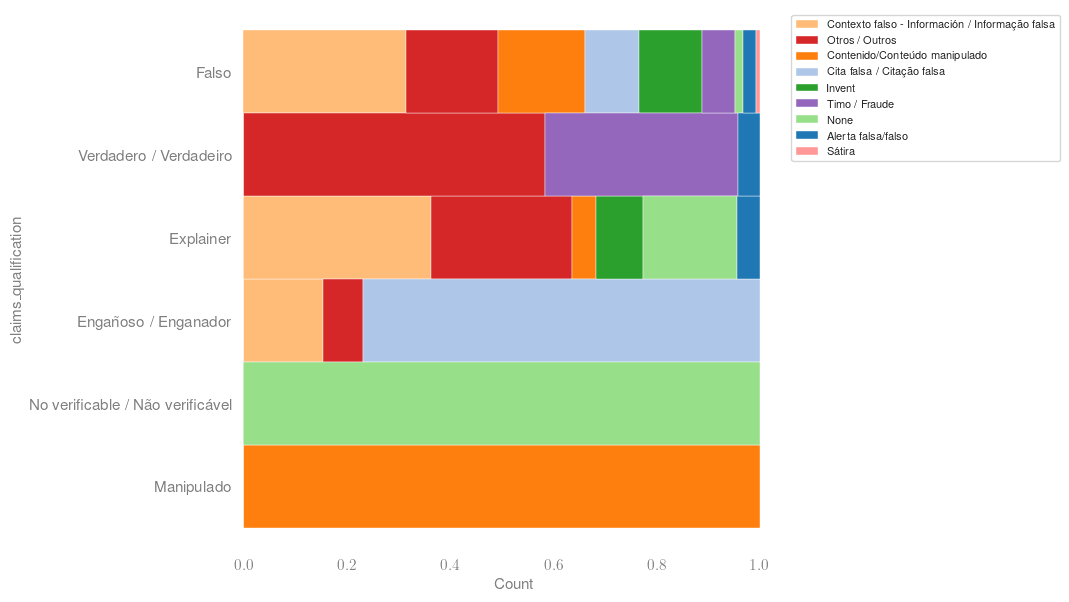

In [63]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Category VS Source

In [64]:
field1 = 'categories'
field2 = 'sources'
color_palette = colours_source_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

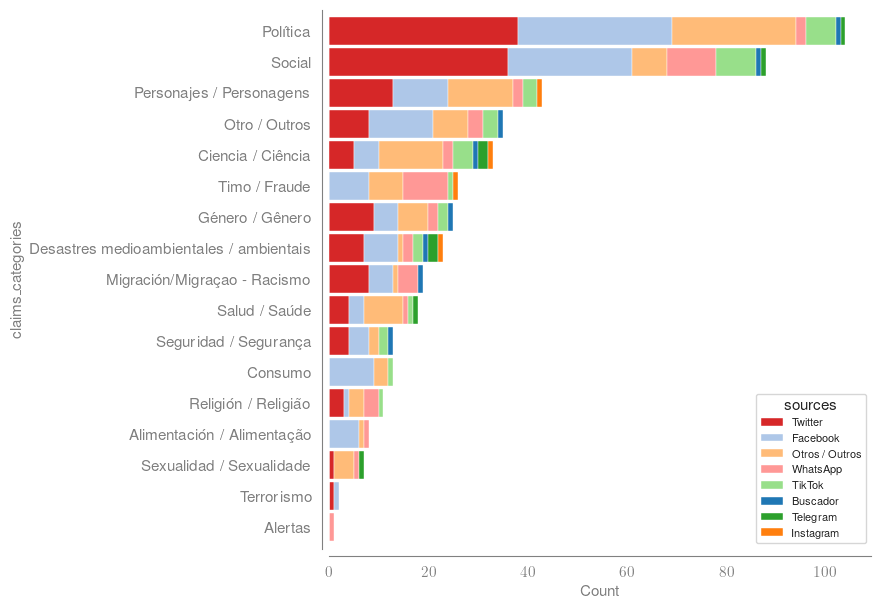

In [65]:
plot_cross(df_to_plot, field1, field2, color_palette, width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

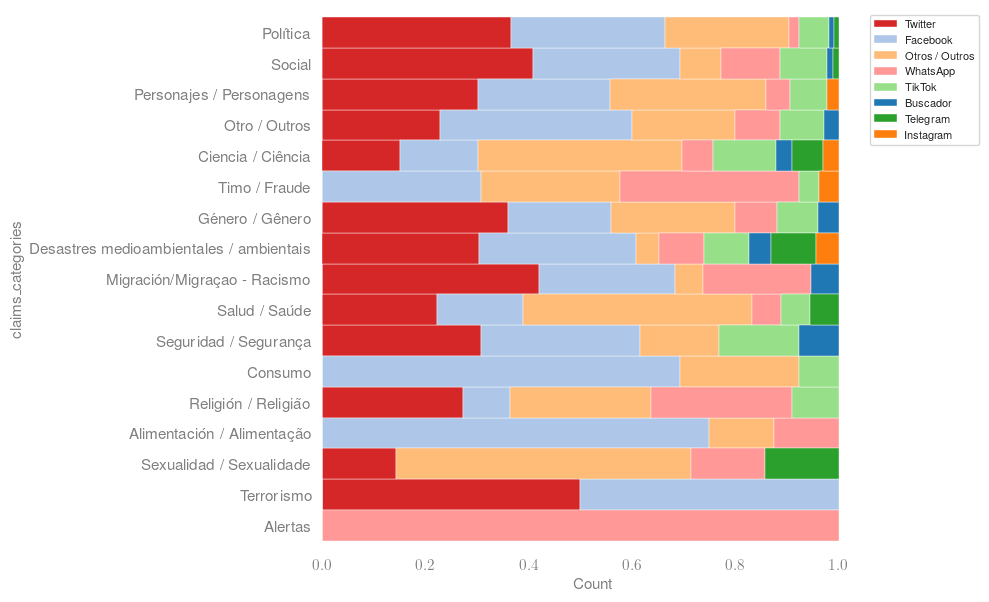

In [66]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Category VS Type of False info

In [67]:
field1 = 'categories'
field2 = 'type'
color_palette = colours_type_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

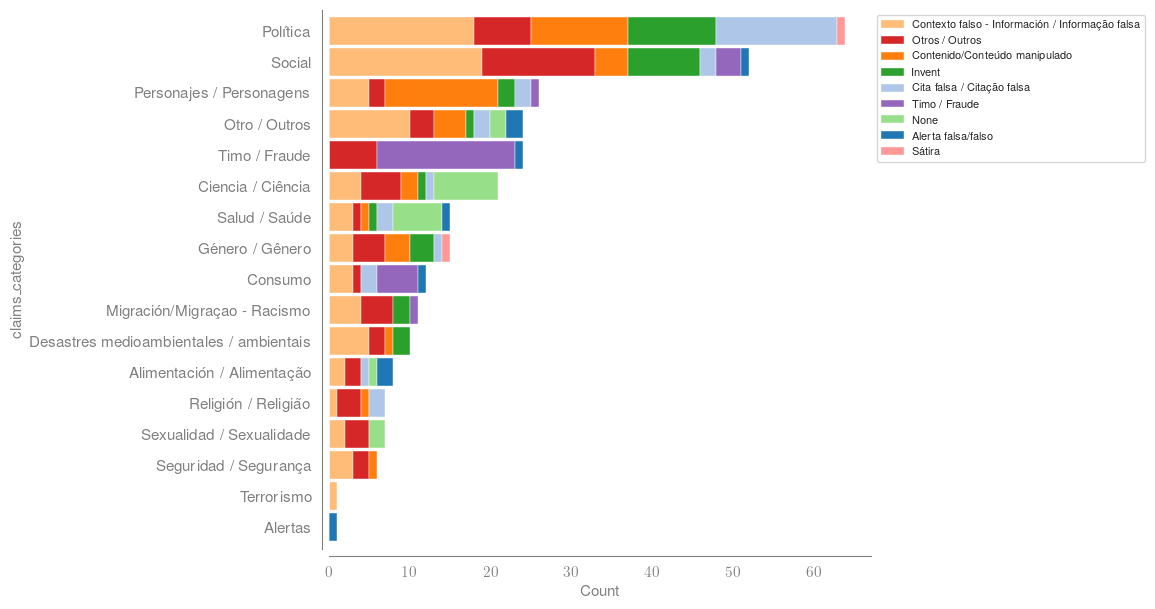

In [68]:
plot_cross(df_to_plot, field1, field2, color_palette, legend_position=(1,1), width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

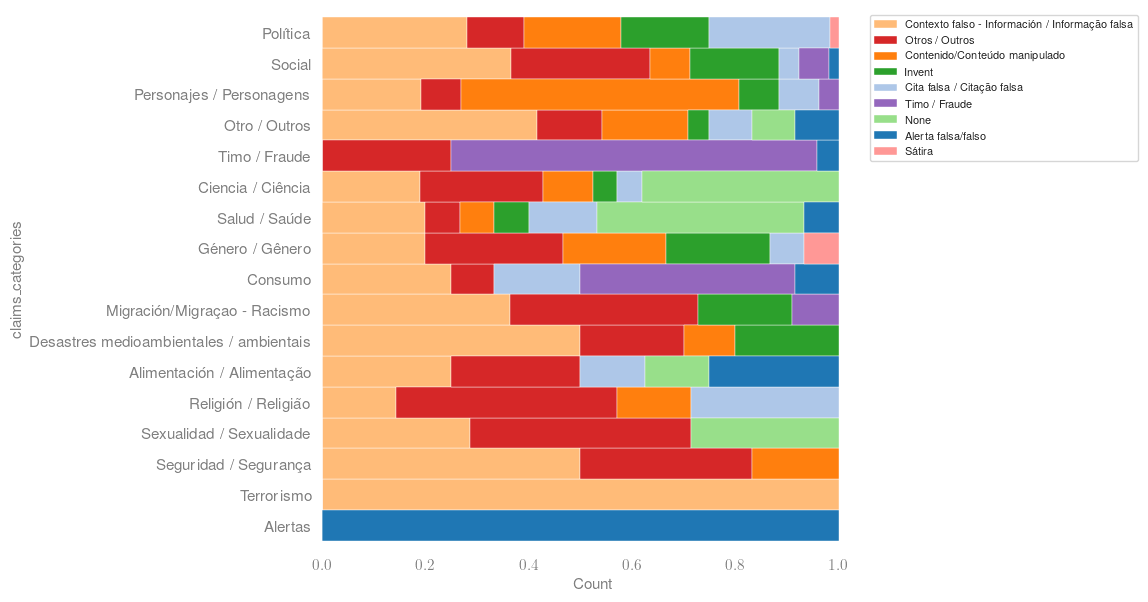

In [69]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

#### Source VS Type of False info

In [70]:
field1 = 'sources'
field2 = 'type'
color_palette = colours_type_claims

df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

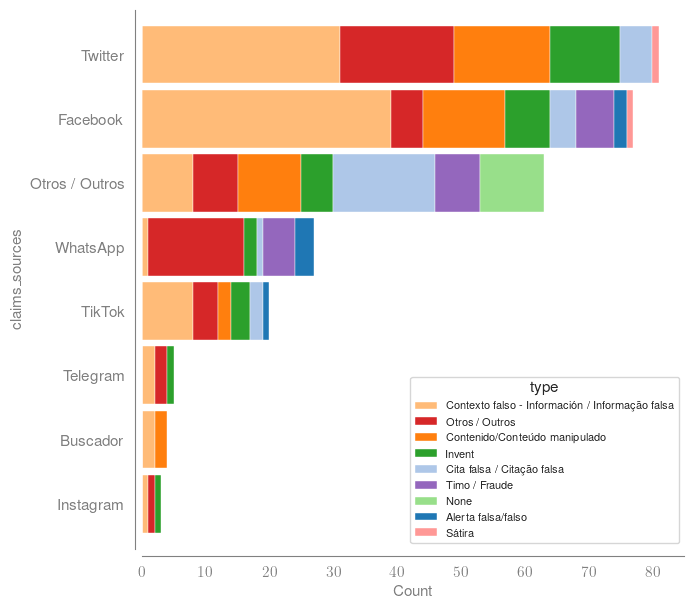

In [71]:
plot_cross(df_to_plot, field1, field2, color_palette, width_bar=0.9, norm=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<module 'matplotlib.pyplot' from '/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

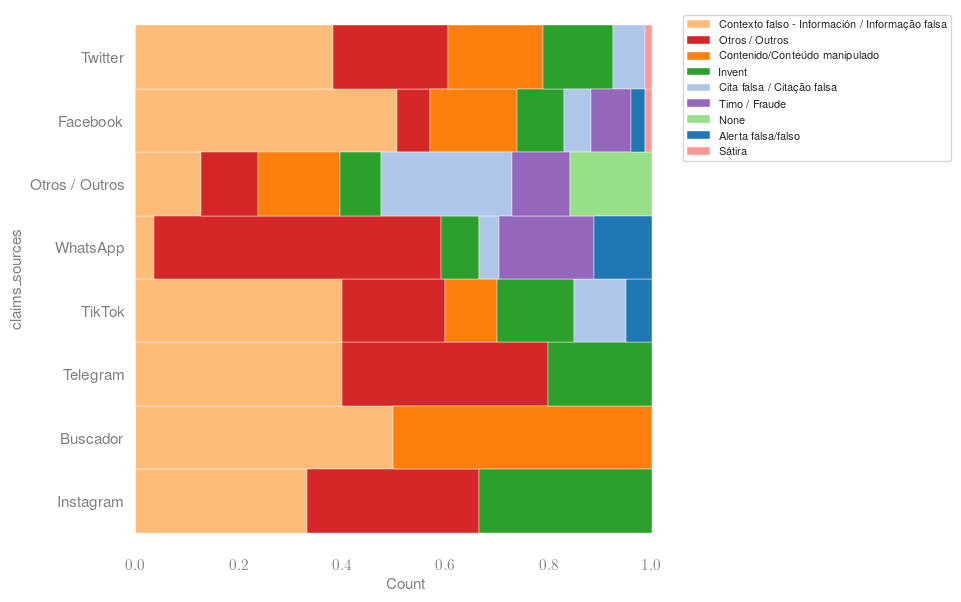

In [72]:
plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, legend_position=(1, 1), norm=True)

## Information about the Twitter API

In [73]:
# Get the number of fact_id per tweets
df_tweets['nbr_facts'] = df_tweets['fact_id'].apply(lambda x: len(x))
# Explode tweets on fact_id list
tweets_exploded = df_tweets.explode('fact_id')

iberifier_columns = ['date', 'sources', 'fact_id', 'categories', 'type', 'fact_checker', 'qualification']
# Merge the iberifier onto the tweets based on the fact_id
tweets_iberifier = pd.merge(tweets_exploded, df_iberifier[iberifier_columns], on='fact_id', how='left')

# Rename the date to avoid confusion
tweets_iberifier = tweets_iberifier.rename(columns={'date_x': 'date_tweet', 'date_y': 'date_fact_check'})
len(tweets_iberifier)

12818

In [74]:
tweets_iberifier.describe()

,retweet_count,reply_count,like_count,quote_count,impression_count,nbr_facts
count,12818.000000,12818.000000,12818.000000,12818.000000,1.281800e+04,12818.000000
mean,11.409658,3.157669,37.318614,0.808238,3.232813e+03,1.061632
std,138.109208,59.197996,581.247690,11.692407,4.278216e+04,0.250039
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000
25%,0.000000,0.000000,0.000000,0.000000,2.000000e+01,1.000000
50%,0.000000,0.000000,0.000000,0.000000,7.100000e+01,1.000000
75%,1.000000,1.000000,3.000000,0.000000,3.500000e+02,1.000000
max,8618.000000,5976.000000,41452.000000,701.000000,2.596463e+06,3.000000


## Amount of tweets per fact_check features

In [75]:
def match_tweet_factcheck_feature(df, feature_columns):
    try:
        group_feature = df.groupby(['fact_id', feature_columns]).size()

    except TypeError: # In case it is a list
        group_feature = df.explode(feature_columns).groupby(['fact_id', feature_columns]).size()
    group_feature = group_feature.reset_index(level='fact_id', drop=True).reset_index()#.sort_values(by=0, ascending=False)
    #group_feature = group_feature.assign(tmp=group_feature.sum(axis=1)).sort_values('tmp', ascending=True).drop(labels='tmp', axis=1)

    return group_feature

In [76]:
def plot_box_tweets(df, feature_columns, color_scheme, legend_position=None,):
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.despine(offset=5, trim=False);

    filename = f"tweets_{feature_columns}"
    order = df.groupby(feature_column).sum().sort_values(by=0, ascending=False).index

    #fig.suptitle(f"{field1} and {field2} of claims [{min(df_iberifier['date'])} - {max(df_iberifier['date'])}]")
    plot = sns.boxplot(grouped_data, y=feature_column, palette= color_scheme, x=0, showfliers = False, order=order)
    ax.set(xlabel=f'')
    ax.set(ylabel=f'')

    ax.tick_params(rotation=0)
    save_plot(fig, ax, filename, sample, legend_position=legend_position)

    
    return plot

#### Qualification

In [77]:
feature_column = 'qualification'
color_scheme = colours_qualification_claims

grouped_data = match_tweet_factcheck_feature(tweets_iberifier, feature_column)
stats_per_features = grouped_data.groupby(feature_column).describe()
stats_per_features.to_csv(f"./tables/{sample}_tweets_per_{feature_column}.csv")
stats_per_features

0                                                        
              count        mean         std  min   25%   50%    75%     max
qualification                                                              
Falso          64.0  198.921875  467.581155  1.0  6.75  23.0  97.75  2108.0

<Axes: >

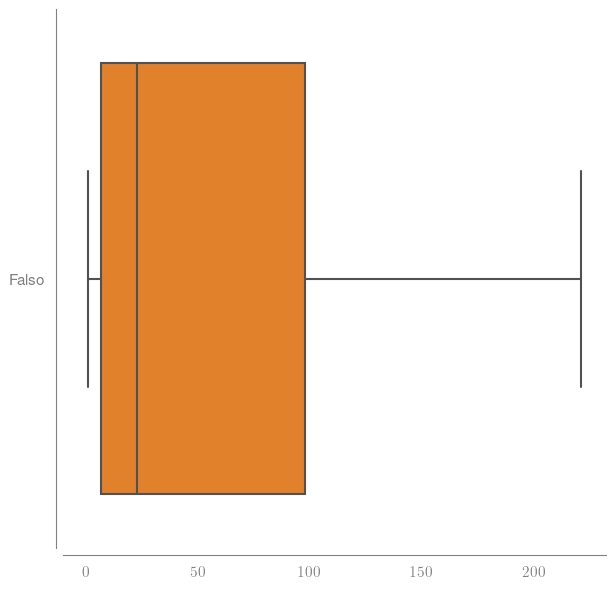

In [78]:
plot_box_tweets(grouped_data, feature_column, color_scheme)

#### Categories

In [79]:
feature_column = 'categories'
color_scheme = colours_cat_claims
grouped_data = match_tweet_factcheck_feature(tweets_iberifier, feature_column)
stats_per_features = grouped_data.groupby(feature_column).describe()
stats_per_features.to_csv(f"./tables/{sample}_tweets_per_{feature_column}.csv")
stats_per_features

0                                \
                                        count        mean         std   min   
categories                                                                    
Ciencia / Ciência                         6.0   73.833333   99.766561   4.0   
Desastres medioambientales / ambientais   2.0    8.000000    5.656854   4.0   
Género / Gênero                           3.0    6.000000    5.000000   1.0   
Migración/Migraçao - Racismo              4.0   79.750000   97.438442   8.0   
Otro / Outros                             3.0    3.666667    3.785939   1.0   
Personajes / Personagens                 17.0  291.294118  651.856077   2.0   
Política                                 32.0  213.937500  445.707624   1.0   
Religión / Religião                       3.0  200.333333  310.187578   5.0   
Salud / Saúde                             3.0   41.000000   56.293872   8.0   
Seguridad / Segurança                     1.0    5.000000         NaN   5.0   
Sexualidad / Sexualidade                  1.0    1.000000         NaN   1.0   
Social                                   24.0  264.458333  573.321443   1.0   
Terrorismo                                1.0   38.000000         NaN  38.0   
Timo / Fraude                             4.0   14.000000    9.899495   3.0   

                                                                      
                                           25%   50%     75%     max  
categories                                                            
Ciencia / Ciência                        12.50  30.5   89.00   263.0  
Desastres medioambientales / ambientais   6.00   8.0   10.00    12.0  
Género / Gênero                           3.50   6.0    8.50    11.0  
Migración/Migraçao - Racismo             19.25  45.0  105.50   221.0  
Otro / Outros                             1.50   2.0    5.00     8.0  
Personajes / Personagens                  6.00  11.0   38.00  2108.0  
Política                                  8.00  25.5  119.50  1713.0  
Religión / Religião                      21.50  38.0  298.00   558.0  
Salud / Saúde                             8.50   9.0   57.50   106.0  
Seguridad / Segurança                     5.00   5.0    5.00     5.0  
Sexualidad / Sexualidade                  1.00   1.0    1.00     1.0  
Social                                    6.75  25.0  124.25  2108.0  
Terrorismo                               38.00  38.0   38.00    38.0  
Timo / Fraude                             9.75  13.0   17.25    27.0

<Axes: >

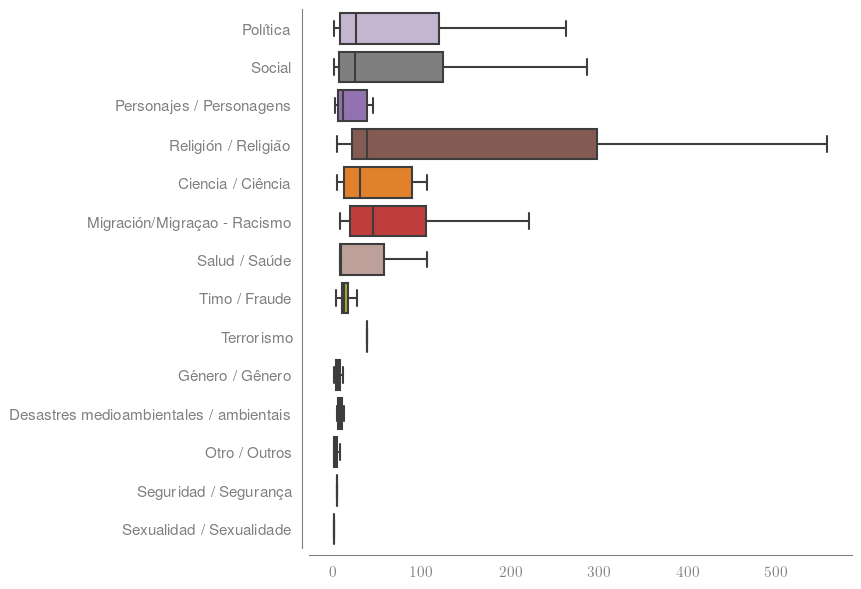

In [80]:
plot_box_tweets(grouped_data, feature_column, color_scheme)

#### Sources

In [81]:
feature_column = 'sources'
color_scheme = colours_source_claims
grouped_data = match_tweet_factcheck_feature(tweets_iberifier, feature_column)
stats_per_features = grouped_data.groupby(feature_column).describe()
stats_per_features.to_csv(f"./tables/{sample}_tweets_per_{feature_column}.csv")
stats_per_features

0                                                       \
               count        mean         std   min    25%    50%      75%   
sources                                                                     
Buscador         1.0    8.000000         NaN   8.0   8.00    8.0     8.00   
Facebook        24.0   71.000000  160.930177   1.0   7.50   23.0    54.50   
Instagram        2.0   11.500000    0.707107  11.0  11.25   11.5    11.75   
Otros / Outros  17.0   96.647059  229.695162   1.0   4.00    6.0    38.00   
TikTok           8.0  118.500000  265.260519   5.0   7.25   17.5    53.25   
Twitter         42.0  208.738095  469.311798   1.0   8.00   23.0   103.25   
WhatsApp         7.0  696.571429  925.711232   7.0  25.00  221.0  1245.00   

                        
                   max  
sources                 
Buscador           8.0  
Facebook         772.0  
Instagram         12.0  
Otros / Outros   926.0  
TikTok           772.0  
Twitter         1932.0  
WhatsApp        2108.0

In [82]:
grouped_data#.groupby('sources').sum()

,sources,0
0,Otros / Outros,263
1,WhatsApp,221
2,Twitter,9
3,Facebook,67
4,Twitter,67
...,...,...
96,TikTok,8
97,Twitter,8
98,Otros / Outros,263
99,Twitter,263


<Axes: >

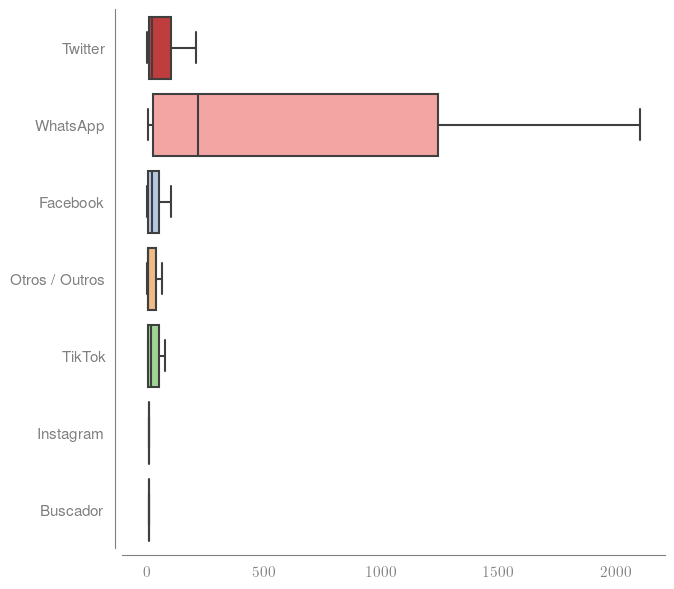

In [83]:
plot_box_tweets(grouped_data, feature_column, color_scheme)

#### Type

In [84]:
feature_column = 'type'
color_scheme = colours_type_claims
grouped_data = match_tweet_factcheck_feature(tweets_iberifier, feature_column)
stats_per_features = grouped_data.groupby(feature_column).describe()
stats_per_features.to_csv(f"./tables/{sample}_tweets_per_{feature_column}.csv")
stats_per_features

0                          \
                                                count        mean         std   
type                                                                            
Cita falsa / Citação falsa                        3.0   14.000000   14.000000   
Contenido/Conteúdo manipulado                    14.0  247.357143  493.453077   
Contexto falso - Información / Informação falsa  18.0  179.555556  419.957592   
Invent                                           12.0   28.833333   32.104470   
Otros / Outros                                   14.0  400.285714  703.797767   
Timo / Fraude                                     3.0   14.666667   12.013881   

                                                                            \
                                                 min    25%    50%     75%   
type                                                                         
Cita falsa / Citação falsa                       4.0   6.00    8.0   19.00   
Contenido/Conteúdo manipulado                    1.0   6.50   18.5  211.75   
Contexto falso - Información / Informação falsa  1.0   5.00   31.5   95.75   
Invent                                           4.0   7.75   11.5   36.25   
Otros / Outros                                   4.0  12.75  113.0  252.50   
Timo / Fraude                                    3.0   8.50   14.0   20.50   

                                                         
                                                    max  
type                                                     
Cita falsa / Citação falsa                         30.0  
Contenido/Conteúdo manipulado                    1713.0  
Contexto falso - Información / Informação falsa  1693.0  
Invent                                             95.0  
Otros / Outros                                   2108.0  
Timo / Fraude                                      27.0

<Axes: >

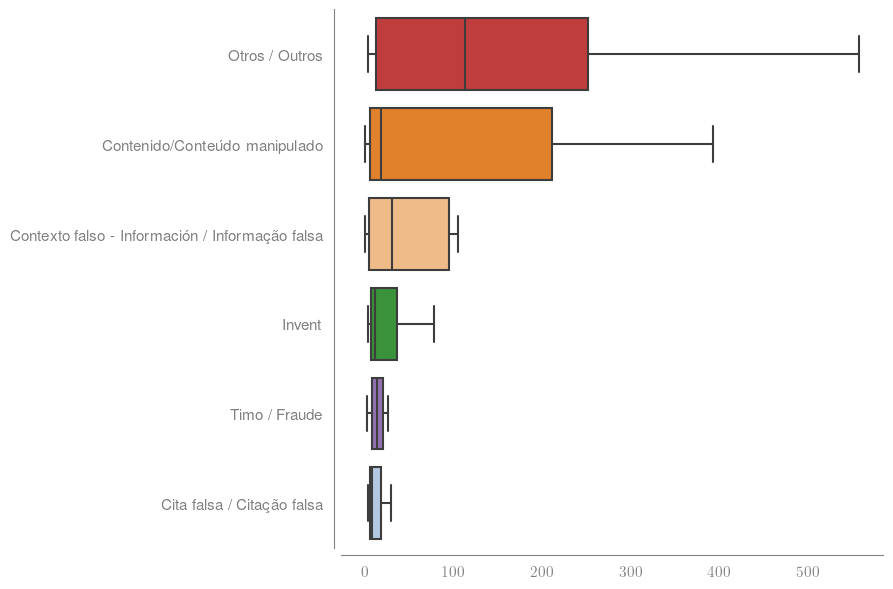

In [85]:
plot_box_tweets(grouped_data, feature_column, color_scheme)

## Information about MyNews API data collection

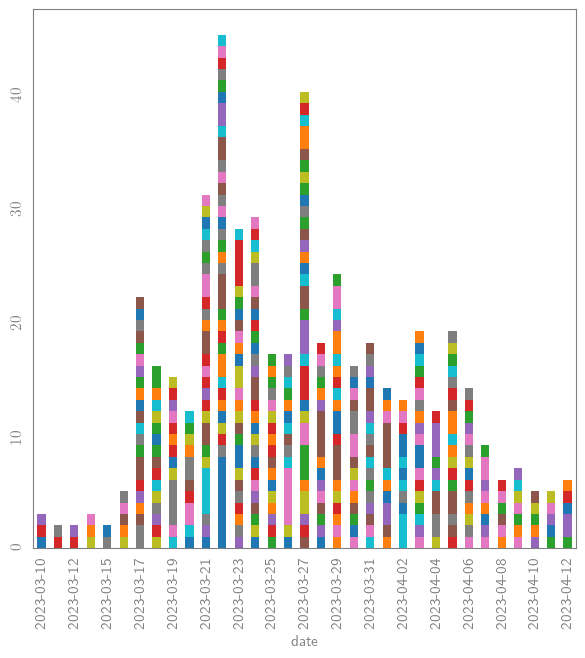

In [86]:
sns.set_style("white")
fig, ax = plt.subplots()

df_mynews.groupby([df_mynews['date'], df_mynews['Newspaper']]).size().unstack().plot.bar(stacked=True, 
                                                                                         ax=ax, 
                                                                                         linewidth=0,
                                                                                         legend=False)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(rotation=90)


#plt.tight_layout()

filename = f'newspaper_overtime_cat'
save_plot(fig, ax, filename, sample)

#plt.savefig('./plots/newspaper_overtime.png', bbox_inches='tight')
plt.show()

## Newspaper parsed

In [87]:
unique_newspapers = df_mynews['Newspaper'].unique().size
unique_newspapers

285

[Text(0.5, 0, 'Numbers of News article per claim')]

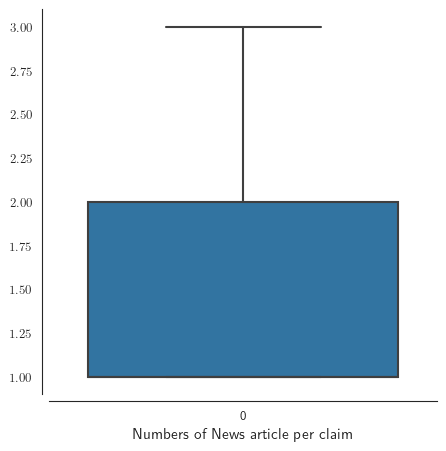

In [88]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5, 5))

sns.despine(offset=5, trim=False);
sns.boxplot(df_mynews.groupby(['Newspaper'] ).size(), showfliers = False)
ax.set(xlabel='Numbers of News article per claim')

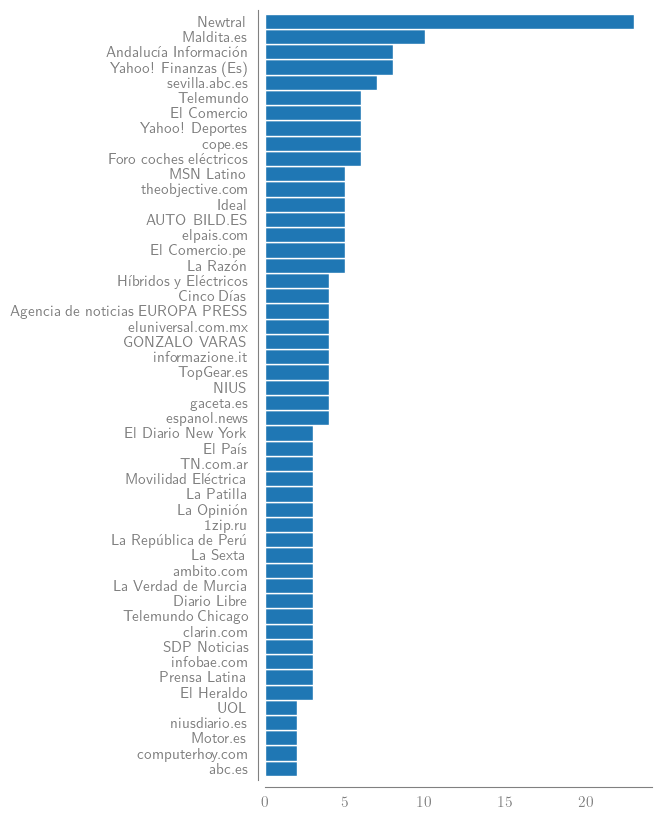

In [89]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(5, 10))

sns.despine(offset=5, trim=False);

df_mynews['Newspaper'].value_counts(ascending=False).head(50).sort_values(ascending=True).plot(kind='barh', ax=ax, width=1)

#plt.tight_layout()


filename = f'top_50_journals'
save_plot(fig, ax, filename, sample, png_size=(5,10), eps_size=(5,10))


plt.show()

## Distribution of tweets and news articles per claims

In [90]:
# Tweets
# Need to explode the list in fact_id before groupby
df_exploded = df_tweets.explode('fact_id')
tweets_grouped = df_exploded.groupby('fact_id').size()#.mean()
#sns.violinplot(data=tweets_grouped, inner='points', cut=0)

# For mynews
mynews_grouped = df_mynews.groupby('fact_id').size()
mynews_grouped

# Concat
count_per_claim = pd.concat([tweets_grouped, mynews_grouped], axis=1, keys=['count_tweets', 'count_articles']).reset_index()
count_per_claim = count_per_claim.fillna(0)
count_per_claim['count_tweets'] = count_per_claim['count_tweets'].astype('int') 
count_per_claim['count_articles'] = count_per_claim['count_articles'].astype('int') 
stat_count_per_claims = count_per_claim.describe().applymap('{:,.1f}'.format)
stat_count_per_claims.to_csv(f"./tables/{sample}stat_count_per_claims.csv")
stat_count_per_claims

,count_tweets,count_articles
count,68.0,68.0
mean,188.5,7.3
std,455.4,13.6
min,0.0,0.0
25%,6.0,1.0
50%,21.5,3.0
75%,82.2,5.2
max,"2,108.0",67.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


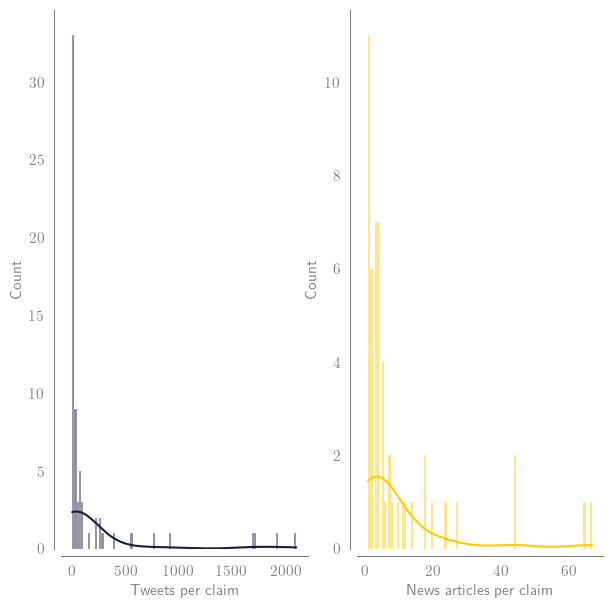

In [117]:
sns.set_style("white")

fig, ax = plt.subplots(1,2)
#fig.suptitle('Distribution of Tweets and news articles per claim')
sns.despine(offset=5, trim=False);

sns.histplot(tweets_grouped, kde=True, ax=ax[0], bins=100, label='Tweets', color=main_color)
ax[0].set(xlabel='Tweets per claim')

sns.histplot(mynews_grouped, kde=True,  ax=ax[1], bins=100, label="News articles", color=second_color)
ax[1].set(xlabel='News articles per claim')


filename = f'tweets_news_per_claims_hist'
save_plot(fig, ax, filename, sample)

plt.show()

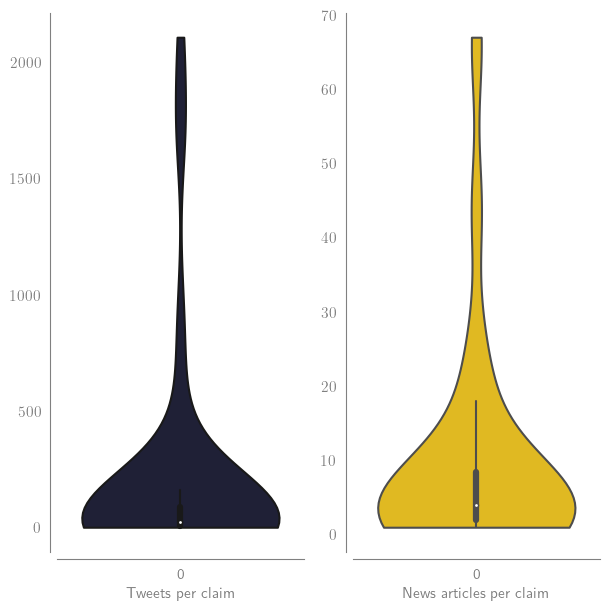

In [120]:
sns.set_style("white")

fig, ax = plt.subplots(1,2)
#fig.suptitle('Distribution of Tweets and news articles per claim')
sns.despine(offset=5, trim=False);

sns.violinplot(tweets_grouped, kde=True, ax=ax[0],  label='Tweets', color=main_color, cut=0)
ax[0].set(xlabel='Tweets per claim')

sns.violinplot(mynews_grouped, kde=True,  ax=ax[1], label="News articles", color=second_color, cut=0)
ax[1].set(xlabel='News articles per claim')


filename = f'tweets_news_per_claims_violin'
save_plot(fig, ax, filename, sample)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


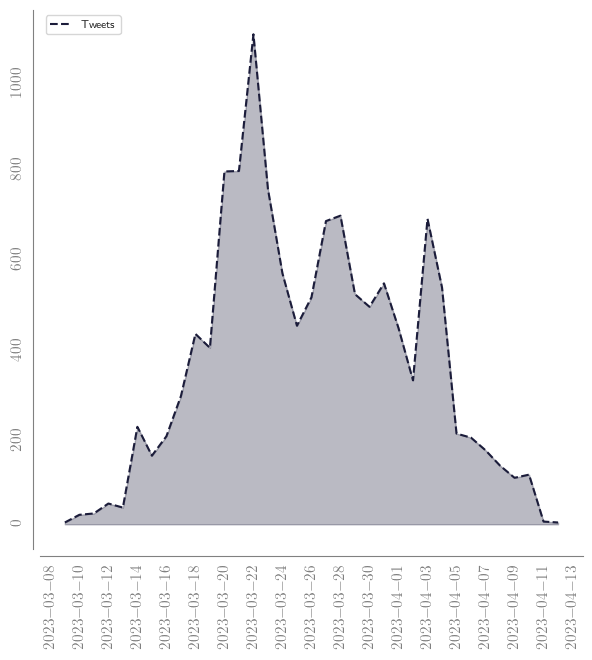

In [93]:
tweets = df_tweets.groupby(df_tweets['date']).size()

fig, ax = plt.subplots()

sns.despine(offset=5, trim=False);

ax.plot_date(tweets.index, tweets.values, '--', label='Tweets', color=main_color)


ax.fill_between(tweets.index, tweets.values, alpha=0.3, color=main_color)


ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(rotation=90)
ax.legend(loc='upper left')


filename = f'tweets_overtime'
save_plot(fig, ax, filename, sample)


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


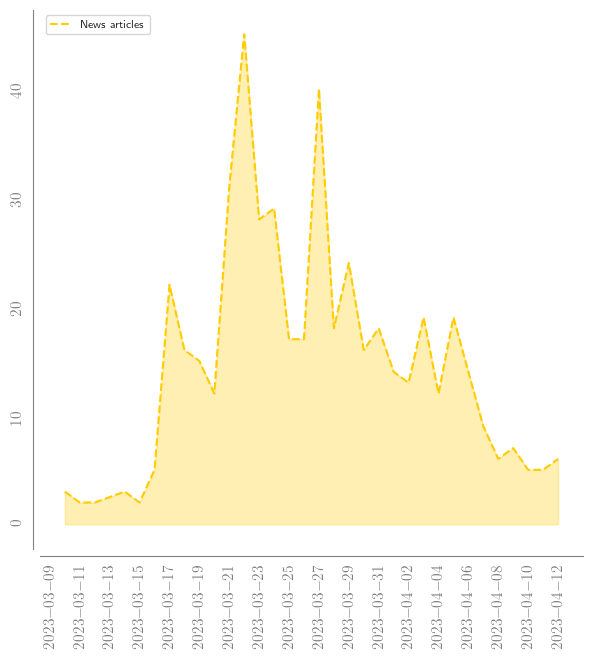

In [94]:
mynews = df_mynews.groupby(df_mynews['date']).size()

fig, ax = plt.subplots()

sns.despine(offset=5, trim=False);


ax.plot_date(mynews.index, mynews.values, '--', label='News articles', color=second_color)

ax.fill_between(mynews.index, mynews.values, alpha=0.3, color=second_color)


ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(rotation=90)
ax.legend(loc='upper left')


filename = f'mynews_overtime'
save_plot(fig, ax, filename, sample)


plt.show()

### Merged plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


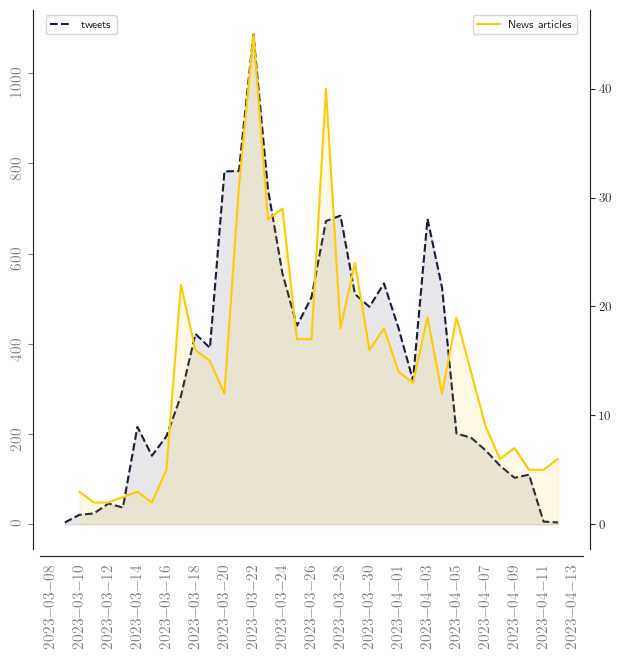

In [95]:
sns.set_style("white")

fig, ax = plt.subplots()

sns.despine(offset=5, trim=False);

ax.plot_date(tweets.index, tweets.values, '--', label='tweets', color=main_color)


ax.fill_between(tweets.index, tweets.values, alpha=0.1, color=main_color)

ax2 = ax.twinx()
ax2.plot_date(mynews.index, mynews.values, '-', label='News articles', color=second_color)
ax2.fill_between(mynews.index, mynews.values, alpha=0.1, color=second_color)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(rotation=90)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
sns.despine(offset=5, trim=False, right=False);


filename = f'tweets_news_overtime'
save_plot(fig, ax, filename, sample)


plt.show()

# Impact of fact check

In [96]:
# The only interest here is on the outliers versus no outliers. All the data will come with the 'on_topic'
# So sample will be 
# outliers and wo_outliers
if sample == 'wo_outliers':
    pass

In [97]:
# Calculate the difference in time between the time the tweet is published and the fact-check
tweets_iberifier['diff_date'] = (tweets_iberifier['date_tweet'] - tweets_iberifier['date_fact_check']).dt.days
tweets_iberifier['diff_date'] = tweets_iberifier['diff_date'].fillna(0)
tweets_iberifier['diff_date'] = tweets_iberifier['diff_date'].astype('int') 

# Groupby and get the impact size for each of fact_id - Fill nan with 0 as it means nothing was collected before

                                                                                                  
             
# Create the diff date for the plot
diff_date = tweets_iberifier.groupby(['fact_id', 'diff_date']).size().reset_index()
diff_date_per_factchecker = tweets_iberifier.groupby(['fact_id', 'diff_date', 'fact_checker']).size().reset_index()[['diff_date', 'fact_checker', 0]]
diff_date_per_support_claim = tweets_iberifier.groupby(['fact_id', 'diff_date', 'claim_finer_relation']).size().reset_index()[['diff_date', 'claim_finer_relation', 0]]

## Grouping by tweets metrics
diff_date_metrics = tweets_iberifier.groupby(['fact_id', 'diff_date']).agg({'retweet_count': 'mean', 
                                                              'reply_count': 'mean', 
                                                              'like_count': 'mean',
                                                              'quote_count': 'mean',
                                                              'impression_count': 'mean'})

diff_date_metrics_support_claim = tweets_iberifier.groupby(['fact_id', 'diff_date', 'claim_finer_relation']).agg({'retweet_count': 'mean', 
                                                              'reply_count': 'mean', 
                                                              'like_count': 'mean',
                                                              'quote_count': 'mean',
                                                              'impression_count': 'mean'})

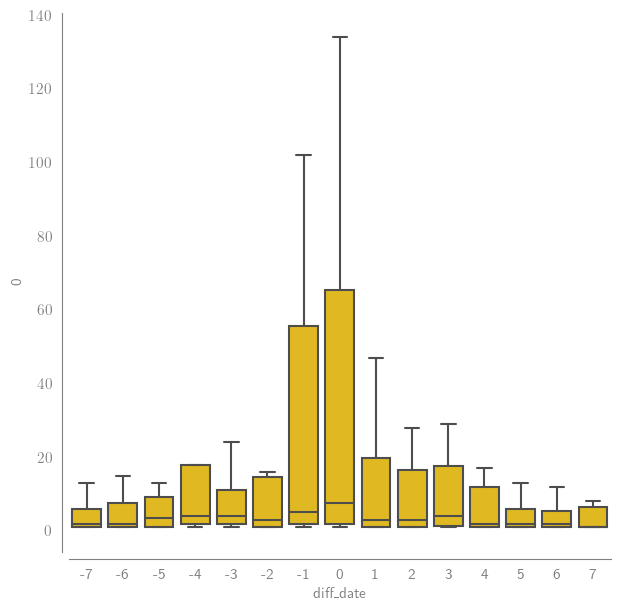

In [98]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))

sns.despine(offset=5, trim=False)
sns.boxplot(diff_date, x='diff_date', y=0, color=second_color, showfliers=False)
filename = f'impact_tweets_bar_all'
save_plot(fig, ax, filename, sample)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


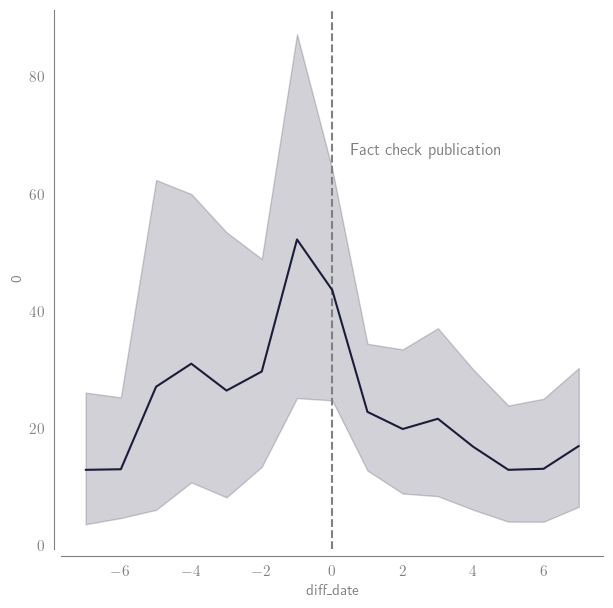

In [99]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))

sns.despine(offset=5, trim=False)
ax.axvline(x=0, color='grey', linestyle='--')
ax = sns.lineplot(diff_date, x='diff_date', y=0, color=main_color)
ax.text(x=2.7, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top' )
filename = f'impact_tweets_line_all'
save_plot(fig, ax, filename, sample)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


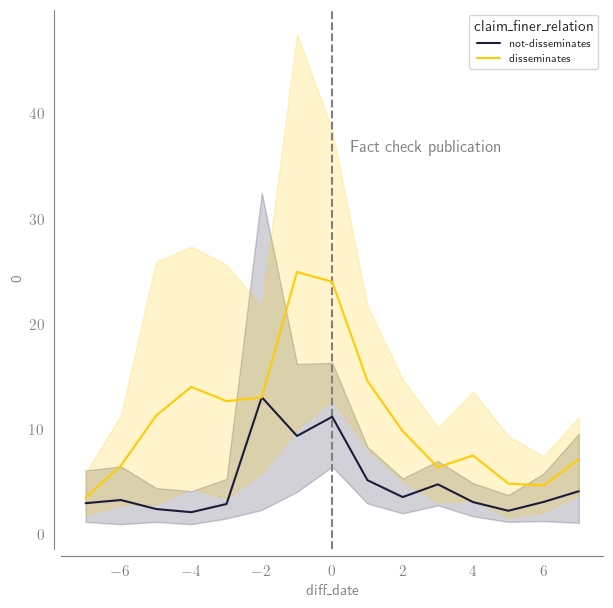

In [100]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))
sns.despine(offset=5, trim=False)
ax.axvline(x=0, color='grey', linestyle='--')

ax = sns.lineplot(diff_date_per_support_claim, x='diff_date', hue='claim_finer_relation', y=0, palette=[main_color, second_color])
ax.text(x=2.7, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top' )
filename = f'impact_tweets_claim_finer_relation'
save_plot(fig, ax, filename, sample)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


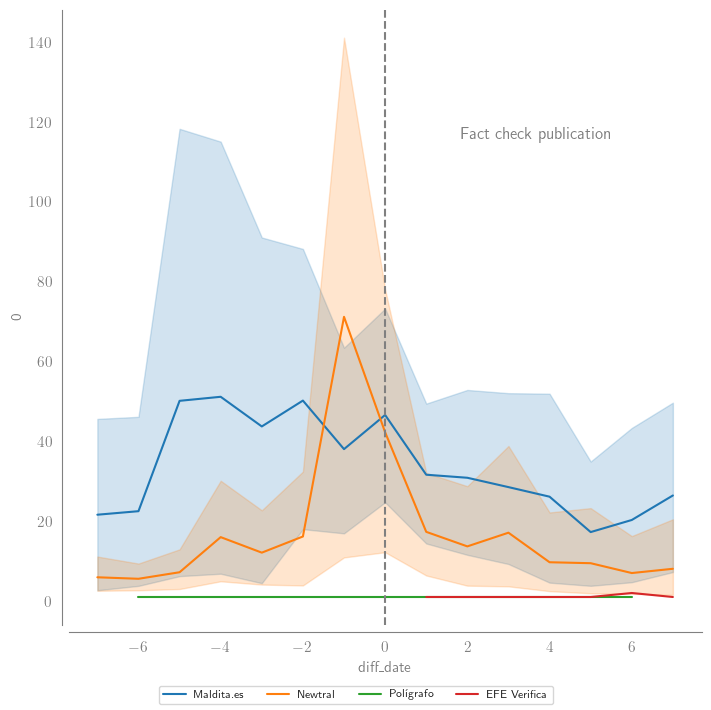

In [101]:
sns.set_style("white")

fig, ax = plt.subplots(layout='constrained')

sns.despine(offset=5, trim=False)

ax = sns.lineplot(diff_date_per_factchecker, x='diff_date', hue='fact_checker', y=0)
ax.axvline(x=0, color='grey', linestyle='--')
ax.text(x=3.7, y=ax.get_ylim()[1]-ax.get_ylim()[1]/5, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top' )

fig.legend(loc='outside lower center', ncol=5)
ax.legend().remove()

filename = f'impact_tweets_factcheckers'
save_plot(fig, ax, filename, sample)

### Difference in counts rather than raw number of tweets

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


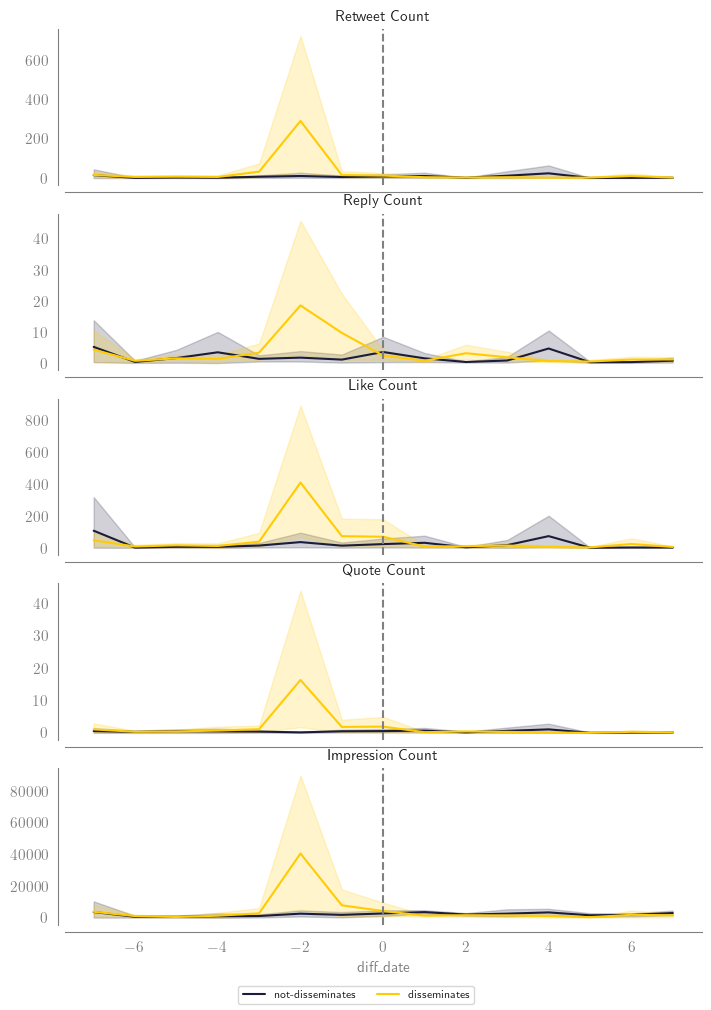

In [102]:
# define the subplots
fig, ax = plt.subplots(5,  sharex=True, layout='constrained')

sns.despine(offset=5, trim=False)

# plot each line in a separate subplot
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='retweet_count', hue='claim_finer_relation', palette=[main_color, second_color], ax=ax[0])
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='reply_count', hue='claim_finer_relation', palette=[main_color, second_color], ax=ax[1], legend=None)
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='like_count', hue='claim_finer_relation',palette=[main_color, second_color],  ax=ax[2], legend=None)
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='quote_count', hue='claim_finer_relation',palette=[main_color, second_color], ax=ax[3], legend=None)
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='impression_count', hue='claim_finer_relation',palette=[main_color, second_color], ax=ax[4], legend=None)


# Draw line for the event
ax[0].axvline(x=0, ymax=ax[0].get_ylim()[1]/2, color='grey', linestyle='--')
ax[1].axvline(x=0, ymax=ax[1].get_ylim()[1]/2, color='grey', linestyle='--')
ax[2].axvline(x=0, ymax=ax[2].get_ylim()[1]/2, color='grey', linestyle='--')
ax[3].axvline(x=0, ymax=ax[3].get_ylim()[1]/2, color='grey', linestyle='--')
ax[4].axvline(x=0, ymax=ax[4].get_ylim()[1]/2, color='grey', linestyle='--')

# add titles and axis labels
ax[0].set_title('Retweet Count')
ax[1].set_title('Reply Count')
ax[2].set_title('Like Count')
ax[3].set_title('Quote Count')
ax[4].set_title('Impression Count')

# Removing y-axis labels
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')
ax[4].set_ylabel('')

# create a legend axis
#legend_ax = fig.add_axes([0.85, 0.5, 0.1, 0.1])

# get the handles and labels from each subplot
#handles, labels = [], []
#for ax in axes:
#    for h, l in zip(*ax.get_legend_handles_labels()):
#        handles.append(h)
#        labels.append(l)

# add the legend to the legend axis
#legend_ax.legend(handles, labels, loc='center', title='Fact ID')
# Put a legend below current axis
#fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
         # fancybox=True, shadow=True, ncol=5)
fig.legend(loc='outside lower center', ncol=2)
ax[0].legend().remove()
filename = f'impact_tweets_metrics'
save_plot(fig, ax, filename, sample, png_size=(7, 10))
plt.show()

## Test to see a difference before and after

In [103]:
tweets_iberifier['impact'] = np.where(tweets_iberifier['diff_date'] <=0, 'Before/fact-check', np.where(tweets_iberifier['diff_date'] >0, 'After', 'ERROR'))
impact = tweets_iberifier.groupby(['fact_id', 'impact']).size().reset_index().fillna(0)   
before = impact[impact['impact'] == 'Before/fact-check']
after = impact[impact['impact'] == 'After']
fact_both = list(set(before['fact_id']).intersection(after['fact_id']))
len(fact_both)

51

In [104]:
before_array = before[before['fact_id'].isin(fact_both)][0]
after_array = after[after['fact_id'].isin(fact_both)][0]


The data does not follow a normal distribution (p = 0.0000)


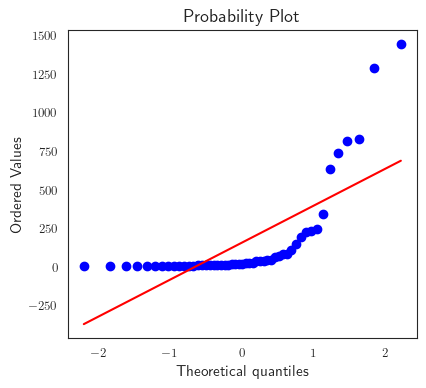

In [105]:

# Plot the data
fig, ax = plt.subplots()
stats.probplot(before_array, plot=ax)

# Test for normality
k2, p = stats.normaltest(before_array)
alpha = 0.05

if p < alpha:
    print("The data does not follow a normal distribution (p = {:.4f})".format(p))
else:
    print("The data follows a normal distribution (p = {:.4f})".format(p))

plt.show()


The data does not follow a normal distribution (p = 0.0000)


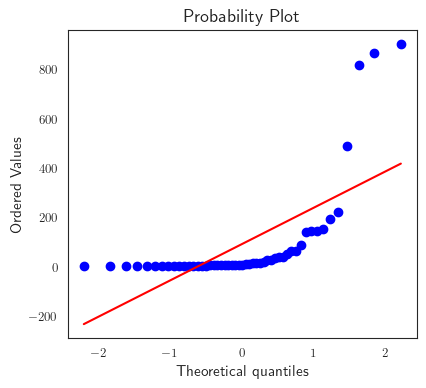

In [106]:

# Plot the data
fig, ax = plt.subplots()
stats.probplot(after_array, plot=ax)

# Test for normality
k2, p = stats.normaltest(after_array)
alpha = 0.05

if p < alpha:
    print("The data does not follow a normal distribution (p = {:.4f})".format(p))
else:
    print("The data follows a normal distribution (p = {:.4f})".format(p))

plt.show()


In [107]:
t, p = stats.wilcoxon(before_array, after_array)
t, p

(246.5, 0.0022177060433167407)

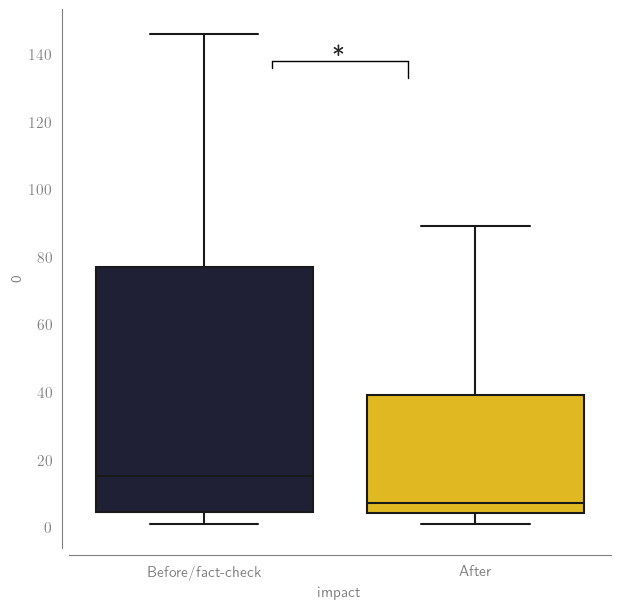

In [108]:
order = ['Before/fact-check', 'After']

sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))
sns.despine(offset=5, trim=False)

sns.boxplot(impact, x='impact', y=0, order=order, showfliers=False, palette=[main_color, second_color])
# calculate the y position for the markers
ypos = ax.get_ylim()[1] * 0.9

# add significance markers
if p < 0.05:
    ax.plot([0.25, 0.75], [ypos, ypos], linewidth=1, color='black')
    ax.plot([0.25, 0.25], [ypos-2, ypos+0.05], linewidth=1, color='black')
    ax.plot([0.75, 0.75], [ypos-5, ypos+0.05], linewidth=1, color='black')
    ax.text(0.5, ypos, '*', ha='center', va='bottom', fontsize=20)

filename = f'impact_tweets_test'
save_plot(fig, ax, filename, sample)
plt.show()

### Same without outliers

In [109]:
# Calculate the first and third quartiles (Q1 and Q3)
Q1 = before[0].quantile(0.25)
Q3 = before[0].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Calculate the inner and outer fences
inner_fence = Q1 - 1.5 * IQR
outer_fence = Q3 + 1.5 * IQR

# Identify the outliers
before_outliers = before[(before[0] < inner_fence) | (before[0] > outer_fence)]


# Calculate the first and third quartiles (Q1 and Q3)
Q1 = after[0].quantile(0.25)
Q3 = after[0].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Calculate the inner and outer fences
inner_fence = Q1 - 1.5 * IQR
outer_fence = Q3 + 1.5 * IQR

# Identify the outliers
after_outliers = after[(after[0] < inner_fence) | (after[0] > outer_fence)]

before_without_outliers = before[~before['fact_id'].isin(before_outliers['fact_id'])]
after_without_outliers = after[~after['fact_id'].isin(after_outliers['fact_id'])]
# Building the list to remove the outliers in both data
fact_both_wo_out = list(set(before_without_outliers['fact_id']).intersection(after_without_outliers['fact_id']))
before_array_wo_out = before_without_outliers[before_without_outliers['fact_id'].isin(fact_both_wo_out)][0]
after_array_wo_out = after_without_outliers[after_without_outliers['fact_id'].isin(fact_both_wo_out)][0]

The data does not follow a normal distribution (p = 0.0000)


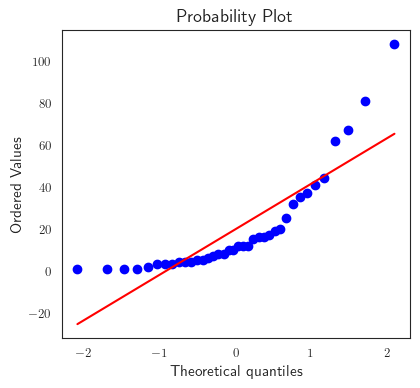

In [110]:

# Plot the data
fig, ax = plt.subplots()
stats.probplot(before_array_wo_out, plot=ax)

# Test for normality
k2, p = stats.normaltest(before_array_wo_out)
alpha = 0.05

if p < alpha:
    print("The data does not follow a normal distribution (p = {:.4f})".format(p))
else:
    print("The data follows a normal distribution (p = {:.4f})".format(p))

plt.show()

The data does not follow a normal distribution (p = 0.0000)


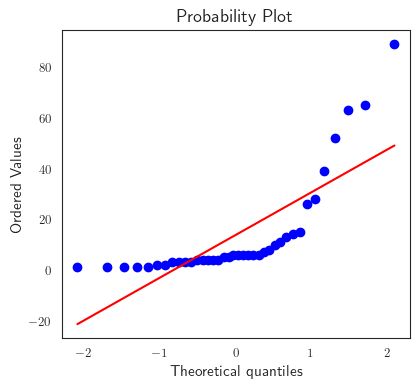

In [111]:
# Plot the data
fig, ax = plt.subplots()
stats.probplot(after_array_wo_out, plot=ax)

# Test for normality
k2, p = stats.normaltest(after_array_wo_out)
alpha = 0.05

if p < alpha:
    print("The data does not follow a normal distribution (p = {:.4f})".format(p))
else:
    print("The data follows a normal distribution (p = {:.4f})".format(p))

plt.show()


In [112]:
t_out, p_out = stats.wilcoxon(before_array_wo_out, after_array_wo_out)
t_out, p_out

/home/olivier/.cache/pypoetry/virtualenvs/iberifier-KmB0-QDJ-py3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


(143.0, 0.02361025826661189)

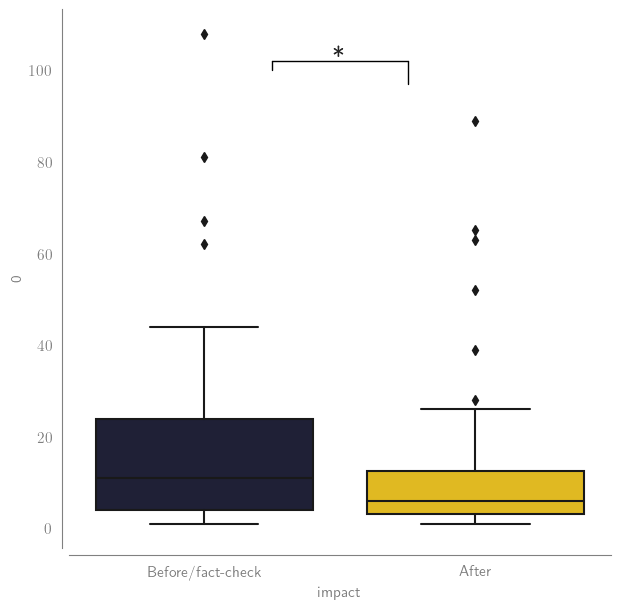

In [113]:
order = ['Before/fact-check', 'After']

sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))
sns.despine(offset=5, trim=False)

sns.boxplot(impact[impact['fact_id'].isin(fact_both_wo_out)], x='impact', y=0, order=order, showfliers=True, palette=[main_color, second_color])
# calculate the y position for the markers
ypos = ax.get_ylim()[1] * 0.9

# add significance markers
if p < 0.05:
    ax.plot([0.25, 0.75], [ypos, ypos], linewidth=1, color='black')
    ax.plot([0.25, 0.25], [ypos-2, ypos+0.05], linewidth=1, color='black')
    ax.plot([0.75, 0.75], [ypos-5, ypos+0.05], linewidth=1, color='black')
    ax.text(0.5, ypos, '*', ha='center', va='bottom', fontsize=20)
    
    
filename = f'impact_tweets_test_wo_outliers'
save_plot(fig, ax, filename, sample)
plt.show()

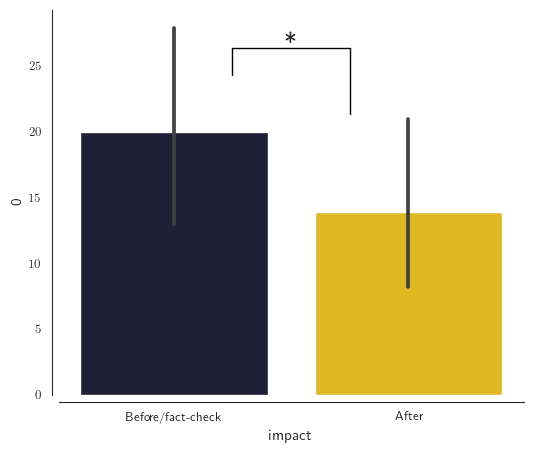

In [114]:
order = ['Before/fact-check', 'After']

sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))
sns.despine(offset=5, trim=False)

sns.barplot(impact[impact['fact_id'].isin(fact_both_wo_out)], x='impact', y=0, order=order, palette=[main_color, second_color])
# calculate the y position for the markers
ypos = ax.get_ylim()[1] * 0.9

# add significance markers
if p_out < 0.05:
    ax.plot([0.25, 0.75], [ypos, ypos], linewidth=1, color='black')
    ax.plot([0.25, 0.25], [ypos-2, ypos+0.05], linewidth=1, color='black')
    ax.plot([0.75, 0.75], [ypos-5, ypos+0.05], linewidth=1, color='black')
    ax.text(0.5, ypos, '*', ha='center', va='bottom', fontsize=20)
